In [1]:
# Import necessary packages
import os
import re
import pdfminer
import sys
import traceback
import pandas as pd
import numpy as np
from subprocess import check_output
from bs4 import BeautifulSoup
from collections import defaultdict
import matplotlib.pyplot as plt
from datetime import date, datetime
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression

In [171]:
pd.set_option('display.max_rows', None)

In [2]:
mpd = pd.read_csv("Cleaned Meeting Data.csv")
mpd

,Meeting_ID,Topic,Scheduled_Start_Time,Zoom_Meeting_Start_Time,Zoom_Meeting_End_Time,Duration,Participants,Recording,Agenda_Link,Minutes_Link,Start_Date,Start_Time,Meeting_Duration,Committee
0,954 410 442,CCEC,4:30:00 PM,2020-03-31 15:40:00,2020-03-31 18:27:00,2:47:55,52,Yes,https://madison.legistar.com/View.ashx?M=A&ID=...,https://madison.legistar.com/View.ashx?M=M&ID=...,3/31/2020,15:40,0 days 02:47:00.000000000,Common Council Executive Committee
1,531 697 510,Common Council,6:30:00 PM,2020-03-31 17:04:00,2020-04-01 02:53:00,9:48:36,337,Yes,https://madison.legistar.com/View.ashx?M=A&ID=...,https://madison.legistar.com/View.ashx?M=M&ID=...,3/31/2020,17:04,0 days 09:49:00.000000000,Common Council Executive Committee
2,411 578 576,"Finance Committee: Meeting of April 6, 2020",4:30:00 PM,2020-04-06 15:40:00,2020-04-06 17:49:00,2:09:00,31,Yes,https://madison.legistar.com/View.ashx?M=A&ID=...,https://madison.legistar.com/View.ashx?M=M&ID=...,4/6/2020,15:40,0 days 02:09:00.000000000,Finance Committee
3,563 608 269,"CCEC: Meeting of April 9, 2020",6:00:00 PM,2020-04-09 16:57:00,2020-04-09 19:53:00,2:56:08,36,Yes,https://madison.legistar.com/View.ashx?M=A&ID=...,https://madison.legistar.com/View.ashx?M=M&ID=...,4/9/2020,16:57,0 days 02:56:00.000000000,Common Council Executive Committee
4,468 948 855,"Plan Commission: Meeting of April 13, 2020",5:30:00 PM,2020-04-13 16:35:00,2020-04-13 21:14:00,4:38:54,80,Yes,https://madison.legistar.com/View.ashx?M=A&ID=...,https://madison.legistar.com/View.ashx?M=M&ID=...,4/13/2020,16:35,0 days 04:39:00.000000000,Plan Commission
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,934 9101 4777,Public Safety Review Committee Budget Subcommi...,NaN,2020-07-29 17:46:00,2020-07-29 20:17:00,2:30:50,21,Yes,NaN,NaN,7/29/2020,17:46,0 days 02:31:00.000000000,Public Safety Review Committee
151,985 6384 8547,"Plan Commission: Meeting of July 30, 2020",5:00:00 PM,2020-07-30 15:58:00,2020-07-30 20:06:00,4:08:29,54,Yes,https://madison.legistar.com/View.ashx?M=A&ID=...,https://madison.legistar.com/View.ashx?M=M&ID=...,7/30/2020,15:58,0 days 04:08:00.000000000,Plan Commission
152,998 8578 7121,Body-Worn Camera Feasibility Review Committee:...,5:30:00 PM,2020-07-30 17:06:00,2020-07-30 19:35:00,2:28:11,23,Yes,https://madison.legistar.com/View.ashx?M=A&ID=...,https://madison.legistar.com/View.ashx?M=M&ID=...,7/30/2020,17:06,0 days 02:29:00.000000000,Body-Worn Camera Feasibility Review Committee
153,949 7219 5424,Task Force on Municipal Golf in Madison Parks:...,6:00:00 PM,2020-07-30 17:35:00,2020-07-30 20:24:00,2:49:27,81,Yes,https://madison.legistar.com/View.ashx?M=A&ID=...,https://madison.legistar.com/View.ashx?M=M&ID=...,7/30/2020,17:35,0 days 02:49:00.000000000,Task Force on Golf in Madison Parks


In [3]:
# !mkdir agenda_pdfs minutes_pdfs

In [5]:
#Fetch all pdfs and make their html format
#Agenda link is the 8th column and the minutes link is the 9th column
for i in range(mpd.shape[0]):
    a_l = mpd.loc[i][8]
    m_l = mpd.loc[i][9]
    if not pd.isnull(a_l) and not pd.isnull(m_l):
        a_l_ipath = os.path.join("agenda_pdfs", str(i) + ".pdf")
        m_l_ipath = os.path.join("minutes_pdfs", str(i) + ".pdf")
        try:
            c1 = check_output(["curl", a_l, "-o", a_l_ipath])
            c2 = check_output(["curl", m_l, "-o", m_l_ipath])
        except:
            traceback.print_exc(file=sys.stdout)
            print(a_l_ipath, m_l_ipath)

Traceback (most recent call last):
  File "<ipython-input-5-68863074649c>", line 10, in <module>
    c1 = check_output(["curl", a_l, "-o", a_l_ipath])
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/subprocess.py", line 411, in check_output
    return run(*popenargs, stdout=PIPE, timeout=timeout, check=True,
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/subprocess.py", line 512, in run
    raise CalledProcessError(retcode, process.args,
subprocess.CalledProcessError: Command '['curl', 'https://madison.legistar.com/View.ashx?M=A&ID=749806&GUID=DCDE4C54-93C7-4202-9D08-3A8E262387B7', '-o', 'agenda_pdfs/0.pdf']' returned non-zero exit status 35.
agenda_pdfs/0.pdf minutes_pdfs/0.pdf
Traceback (most recent call last):
  File "<ipython-input-5-68863074649c>", line 11, in <module>
    c2 = check_output(["curl", m_l, "-o", m_l_ipath])
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/subprocess.py", line 411, in check_outpu

In [4]:
mpd["Agenda HTML"] = ""
mpd["Minutes HTML"] = ""
mpd

,Meeting_ID,Topic,Scheduled_Start_Time,Zoom_Meeting_Start_Time,Zoom_Meeting_End_Time,Duration,Participants,Recording,Agenda_Link,Minutes_Link,Start_Date,Start_Time,Meeting_Duration,Committee,Agenda HTML,Minutes HTML
0,954 410 442,CCEC,4:30:00 PM,2020-03-31 15:40:00,2020-03-31 18:27:00,2:47:55,52,Yes,https://madison.legistar.com/View.ashx?M=A&ID=...,https://madison.legistar.com/View.ashx?M=M&ID=...,3/31/2020,15:40,0 days 02:47:00.000000000,Common Council Executive Committee,,
1,531 697 510,Common Council,6:30:00 PM,2020-03-31 17:04:00,2020-04-01 02:53:00,9:48:36,337,Yes,https://madison.legistar.com/View.ashx?M=A&ID=...,https://madison.legistar.com/View.ashx?M=M&ID=...,3/31/2020,17:04,0 days 09:49:00.000000000,Common Council Executive Committee,,
2,411 578 576,"Finance Committee: Meeting of April 6, 2020",4:30:00 PM,2020-04-06 15:40:00,2020-04-06 17:49:00,2:09:00,31,Yes,https://madison.legistar.com/View.ashx?M=A&ID=...,https://madison.legistar.com/View.ashx?M=M&ID=...,4/6/2020,15:40,0 days 02:09:00.000000000,Finance Committee,,
3,563 608 269,"CCEC: Meeting of April 9, 2020",6:00:00 PM,2020-04-09 16:57:00,2020-04-09 19:53:00,2:56:08,36,Yes,https://madison.legistar.com/View.ashx?M=A&ID=...,https://madison.legistar.com/View.ashx?M=M&ID=...,4/9/2020,16:57,0 days 02:56:00.000000000,Common Council Executive Committee,,
4,468 948 855,"Plan Commission: Meeting of April 13, 2020",5:30:00 PM,2020-04-13 16:35:00,2020-04-13 21:14:00,4:38:54,80,Yes,https://madison.legistar.com/View.ashx?M=A&ID=...,https://madison.legistar.com/View.ashx?M=M&ID=...,4/13/2020,16:35,0 days 04:39:00.000000000,Plan Commission,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,934 9101 4777,Public Safety Review Committee Budget Subcommi...,NaN,2020-07-29 17:46:00,2020-07-29 20:17:00,2:30:50,21,Yes,NaN,NaN,7/29/2020,17:46,0 days 02:31:00.000000000,Public Safety Review Committee,,
151,985 6384 8547,"Plan Commission: Meeting of July 30, 2020",5:00:00 PM,2020-07-30 15:58:00,2020-07-30 20:06:00,4:08:29,54,Yes,https://madison.legistar.com/View.ashx?M=A&ID=...,https://madison.legistar.com/View.ashx?M=M&ID=...,7/30/2020,15:58,0 days 04:08:00.000000000,Plan Commission,,
152,998 8578 7121,Body-Worn Camera Feasibility Review Committee:...,5:30:00 PM,2020-07-30 17:06:00,2020-07-30 19:35:00,2:28:11,23,Yes,https://madison.legistar.com/View.ashx?M=A&ID=...,https://madison.legistar.com/View.ashx?M=M&ID=...,7/30/2020,17:06,0 days 02:29:00.000000000,Body-Worn Camera Feasibility Review Committee,,
153,949 7219 5424,Task Force on Municipal Golf in Madison Parks:...,6:00:00 PM,2020-07-30 17:35:00,2020-07-30 20:24:00,2:49:27,81,Yes,https://madison.legistar.com/View.ashx?M=A&ID=...,https://madison.legistar.com/View.ashx?M=M&ID=...,7/30/2020,17:35,0 days 02:49:00.000000000,Task Force on Golf in Madison Parks,,


In [5]:
#Fetch all pdfs and make their html format
#Agenda link is the 8th column and the minutes link is the 9th column
a_h = []
m_h = []
for i in range(mpd.shape[0]):
    a_l = mpd.loc[i]["Agenda_Link"]
    m_l = mpd.loc[i]["Minutes_Link"]
    if not pd.isnull(a_l) and not pd.isnull(m_l):
        a_l_ipath = os.path.join("agenda_pdfs", str(i) + ".pdf")
        m_l_ipath = os.path.join("minutes_pdfs", str(i) + ".pdf")
        try:
            s1 = check_output(["pdf2txt.py", "-t", "html", "-Y", "loose", a_l_ipath])
            s2 = check_output(["pdf2txt.py", "-t", "html", "-Y", "loose", m_l_ipath])
            #print(mpd.loc[i, 14])
            a_h.append(BeautifulSoup(s1))
            m_h.append(BeautifulSoup(s2))
        except:
            traceback.print_exc(file=sys.stdout)
            print(a_l_ipath, m_l_ipath)
            a_h.append(" ")
            m_h.append(" ")
    else:
        a_h.append(" ")
        m_h.append(" ")
mpd["Agenda HTML"] = a_h
mpd["Minutes HTML"] = m_h

Traceback (most recent call last):
  File "<ipython-input-5-74e19c35fcb1>", line 13, in <module>
    s2 = check_output(["pdf2txt.py", "-t", "html", "-Y", "loose", m_l_ipath])
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/subprocess.py", line 411, in check_output
    return run(*popenargs, stdout=PIPE, timeout=timeout, check=True,
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/subprocess.py", line 512, in run
    raise CalledProcessError(retcode, process.args,
subprocess.CalledProcessError: Command '['pdf2txt.py', '-t', 'html', '-Y', 'loose', 'minutes_pdfs/19.pdf']' returned non-zero exit status 1.
agenda_pdfs/19.pdf minutes_pdfs/19.pdf
Traceback (most recent call last):
  File "<ipython-input-5-74e19c35fcb1>", line 12, in <module>
    s1 = check_output(["pdf2txt.py", "-t", "html", "-Y", "loose", a_l_ipath])
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/subprocess.py", line 411, in check_output
    return run(*

In [6]:
def find_near(x, y):
    for x_ in range(x-5, x+5):
        for y_ in range(y-5, y+5):
            if (x_, y_) in text:
                return text[(x_, y_)]
    return None

In [7]:
agenda_items_list = []
for i in range(mpd.shape[0]):
    a_l = mpd.loc[i]["Agenda HTML"]
    text = {} # key=(x,y), val=text
    #print(page)

    if a_l != " ":
        for div in a_l.find_all("div"):
            style = div.attrs.get("style", "")
            m1 = re.search("left:(\d+)px", style)
            m2 = re.search("top:(\d+)px", style)
            if m1 and m2:
                x, y = int(m1.group(1)), int(m2.group(1))
                text[(x,y)] = div.get_text()

        agenda_list = {}

        for (x,y), t in text.items():
            # agenda items are roughly at x=170
            if 165 < x < 175:
                # agenda numbers are rougly at x=69, same y as text
                num = find_near(103, y)
                if num:
                    #print(num)
                    num = num.replace("*", "")
                    agenda_num = int(re.match('[0-9]+',num).group(0))
                    agenda_list[agenda_num] = t

        agenda_items_list.append(agenda_list)
    
    else:
        agenda_items_list.append({})
mpd["Agenda Items"] = agenda_items_list

In [8]:
m_items_list = []
for i in range(mpd.shape[0]):
    m_l = mpd.loc[i]["Minutes HTML"]
    text = {} # key=(x,y), val=text
    #print(page)

    if m_l != " ":
        for div in m_l.find_all("div"):
            style = div.attrs.get("style", "")
            m1 = re.search("left:(\d+)px", style)
            m2 = re.search("top:(\d+)px", style)
            if m1 and m2:
                x, y = int(m1.group(1)), int(m2.group(1))
                text[(x,y)] = div.get_text()

        #print(text)
        #break
        m_list = {}

        for (x,y), t in text.items():
            if 170 < x < 180:
                num = find_near(102, y)
                if num and re.match('[0-9]+',num) != None:
                    m_num = int(re.match('[0-9]+',num).group(0))
                    m_list[m_num] = t

        m_items_list.append(m_list)
    
    else:
        m_items_list.append({})
#print(len(m_items_list))
mpd["Minutes Items"] = m_items_list

In [9]:
mpd.head(5)

,Meeting_ID,Topic,Scheduled_Start_Time,Zoom_Meeting_Start_Time,Zoom_Meeting_End_Time,Duration,Participants,Recording,Agenda_Link,Minutes_Link,Start_Date,Start_Time,Meeting_Duration,Committee,Agenda HTML,Minutes HTML,Agenda Items,Minutes Items
0,954 410 442,CCEC,4:30:00 PM,2020-03-31 15:40:00,2020-03-31 18:27:00,2:47:55,52,Yes,https://madison.legistar.com/View.ashx?M=A&ID=...,https://madison.legistar.com/View.ashx?M=M&ID=...,3/31/2020,15:40,0 days 02:47:00.000000000,Common Council Executive Committee,"[[[\n, <meta content=""text/html; charset=utf-8...","[[[\n, <meta content=""text/html; charset=utf-8...",{59845: 'Establishing a Body-Worn Camera Feasi...,{59845: 'Establishing a Body-Worn Camera Feasi...
1,531 697 510,Common Council,6:30:00 PM,2020-03-31 17:04:00,2020-04-01 02:53:00,9:48:36,337,Yes,https://madison.legistar.com/View.ashx?M=A&ID=...,https://madison.legistar.com/View.ashx?M=M&ID=...,3/31/2020,17:04,0 days 09:49:00.000000000,Common Council Executive Committee,"[[[\n, <meta content=""text/html; charset=utf-8...","[[[\n, <meta content=""text/html; charset=utf-8...",{59422: 'Commerating the 50th anniversary of E...,{59422: 'Commerating the 50th anniversary of E...
2,411 578 576,"Finance Committee: Meeting of April 6, 2020",4:30:00 PM,2020-04-06 15:40:00,2020-04-06 17:49:00,2:09:00,31,Yes,https://madison.legistar.com/View.ashx?M=A&ID=...,https://madison.legistar.com/View.ashx?M=M&ID=...,4/6/2020,15:40,0 days 02:09:00.000000000,Finance Committee,"[[[\n, <meta content=""text/html; charset=utf-8...","[[[\n, <meta content=""text/html; charset=utf-8...",{60005: 'A Resolution to authorize the noncomp...,{60005: 'A Resolution to authorize the noncomp...
3,563 608 269,"CCEC: Meeting of April 9, 2020",6:00:00 PM,2020-04-09 16:57:00,2020-04-09 19:53:00,2:56:08,36,Yes,https://madison.legistar.com/View.ashx?M=A&ID=...,https://madison.legistar.com/View.ashx?M=M&ID=...,4/9/2020,16:57,0 days 02:56:00.000000000,Common Council Executive Committee,"[[[\n, <meta content=""text/html; charset=utf-8...","[[[\n, <meta content=""text/html; charset=utf-8...",{},{60110: 'Discuss Council's Role & Response dur...
4,468 948 855,"Plan Commission: Meeting of April 13, 2020",5:30:00 PM,2020-04-13 16:35:00,2020-04-13 21:14:00,4:38:54,80,Yes,https://madison.legistar.com/View.ashx?M=A&ID=...,https://madison.legistar.com/View.ashx?M=M&ID=...,4/13/2020,16:35,0 days 04:39:00.000000000,Plan Commission,"[[[\n, <meta content=""text/html; charset=utf-8...","[[[\n, <meta content=""text/html; charset=utf-8...",{60134: 'General Public Correspondence to the ...,{60182: 'Recommendation of Fire Chief regardin...


In [10]:
mpd["Agenda Items"][1], mpd["Minutes Items"][1]
#mpd["Agenda_Link"][1], mpd["Minutes_Link"][1]

({59422: 'Commerating the 50th anniversary of Earth Day on April 22, 2020.\n',
  59542: 'Proclaiming the week of April 26 through May 2, 2020 as Arbor Week in the City \nof Madison.\n',
  59898: "Petition received in the Madison City Clerk's Office 3/6/2020 from Randall A. \nTheis Trust, regarding attachment from the Town of Middleton to the City of \nMadison.\n",
  59954: "Petition received in the Madison City Clerk's Office 3/10/2020 from Edison LLC, \nregarding attachment from the Town of Middleton to the City of Madison.\n",
  59131: 'Creating Section 28.022 - 00418 of the Madison General Ordinances to amend \na Planned Development District at property located at 7050 Watts Road, 1st \nAldermanic District, to approve an Amended General Development Plan.\n',
  59133: 'Creating Section 28.022 -- 00419 of the Madison General Ordinances to change \nthe zoning of property located at 935 West Johnson Street, 8th Aldermanic \nDistrict, from TR-U2 Traditional Residential - Urban District 2

In [11]:
mpd["# Agenda Items"] = [len(d) for d in mpd["Agenda Items"]]
mpd["# Minutes Items"] = [len(d) for d in mpd["Minutes Items"]]

In [12]:
mpd.head(5)

,Meeting_ID,Topic,Scheduled_Start_Time,Zoom_Meeting_Start_Time,Zoom_Meeting_End_Time,Duration,Participants,Recording,Agenda_Link,Minutes_Link,Start_Date,Start_Time,Meeting_Duration,Committee,Agenda HTML,Minutes HTML,Agenda Items,Minutes Items,# Agenda Items,# Minutes Items
0,954 410 442,CCEC,4:30:00 PM,2020-03-31 15:40:00,2020-03-31 18:27:00,2:47:55,52,Yes,https://madison.legistar.com/View.ashx?M=A&ID=...,https://madison.legistar.com/View.ashx?M=M&ID=...,3/31/2020,15:40,0 days 02:47:00.000000000,Common Council Executive Committee,"[[[\n, <meta content=""text/html; charset=utf-8...","[[[\n, <meta content=""text/html; charset=utf-8...",{59845: 'Establishing a Body-Worn Camera Feasi...,{59845: 'Establishing a Body-Worn Camera Feasi...,7,7
1,531 697 510,Common Council,6:30:00 PM,2020-03-31 17:04:00,2020-04-01 02:53:00,9:48:36,337,Yes,https://madison.legistar.com/View.ashx?M=A&ID=...,https://madison.legistar.com/View.ashx?M=M&ID=...,3/31/2020,17:04,0 days 09:49:00.000000000,Common Council Executive Committee,"[[[\n, <meta content=""text/html; charset=utf-8...","[[[\n, <meta content=""text/html; charset=utf-8...",{59422: 'Commerating the 50th anniversary of E...,{59422: 'Commerating the 50th anniversary of E...,116,117
2,411 578 576,"Finance Committee: Meeting of April 6, 2020",4:30:00 PM,2020-04-06 15:40:00,2020-04-06 17:49:00,2:09:00,31,Yes,https://madison.legistar.com/View.ashx?M=A&ID=...,https://madison.legistar.com/View.ashx?M=M&ID=...,4/6/2020,15:40,0 days 02:09:00.000000000,Finance Committee,"[[[\n, <meta content=""text/html; charset=utf-8...","[[[\n, <meta content=""text/html; charset=utf-8...",{60005: 'A Resolution to authorize the noncomp...,{60005: 'A Resolution to authorize the noncomp...,6,6
3,563 608 269,"CCEC: Meeting of April 9, 2020",6:00:00 PM,2020-04-09 16:57:00,2020-04-09 19:53:00,2:56:08,36,Yes,https://madison.legistar.com/View.ashx?M=A&ID=...,https://madison.legistar.com/View.ashx?M=M&ID=...,4/9/2020,16:57,0 days 02:56:00.000000000,Common Council Executive Committee,"[[[\n, <meta content=""text/html; charset=utf-8...","[[[\n, <meta content=""text/html; charset=utf-8...",{},{60110: 'Discuss Council's Role & Response dur...,0,2
4,468 948 855,"Plan Commission: Meeting of April 13, 2020",5:30:00 PM,2020-04-13 16:35:00,2020-04-13 21:14:00,4:38:54,80,Yes,https://madison.legistar.com/View.ashx?M=A&ID=...,https://madison.legistar.com/View.ashx?M=M&ID=...,4/13/2020,16:35,0 days 04:39:00.000000000,Plan Commission,"[[[\n, <meta content=""text/html; charset=utf-8...","[[[\n, <meta content=""text/html; charset=utf-8...",{60134: 'General Public Correspondence to the ...,{60182: 'Recommendation of Fire Chief regardin...,22,15


In [13]:
mpd.at[106, "# Minutes Items"] = 11

In [14]:
mpd.at[51, "# Minutes Items"] = 7

In [15]:
mpd.at[104, "# Minutes Items"] = 11

In [16]:
mpd.head(5)

,Meeting_ID,Topic,Scheduled_Start_Time,Zoom_Meeting_Start_Time,Zoom_Meeting_End_Time,Duration,Participants,Recording,Agenda_Link,Minutes_Link,Start_Date,Start_Time,Meeting_Duration,Committee,Agenda HTML,Minutes HTML,Agenda Items,Minutes Items,# Agenda Items,# Minutes Items
0,954 410 442,CCEC,4:30:00 PM,2020-03-31 15:40:00,2020-03-31 18:27:00,2:47:55,52,Yes,https://madison.legistar.com/View.ashx?M=A&ID=...,https://madison.legistar.com/View.ashx?M=M&ID=...,3/31/2020,15:40,0 days 02:47:00.000000000,Common Council Executive Committee,"[[[\n, <meta content=""text/html; charset=utf-8...","[[[\n, <meta content=""text/html; charset=utf-8...",{59845: 'Establishing a Body-Worn Camera Feasi...,{59845: 'Establishing a Body-Worn Camera Feasi...,7,7
1,531 697 510,Common Council,6:30:00 PM,2020-03-31 17:04:00,2020-04-01 02:53:00,9:48:36,337,Yes,https://madison.legistar.com/View.ashx?M=A&ID=...,https://madison.legistar.com/View.ashx?M=M&ID=...,3/31/2020,17:04,0 days 09:49:00.000000000,Common Council Executive Committee,"[[[\n, <meta content=""text/html; charset=utf-8...","[[[\n, <meta content=""text/html; charset=utf-8...",{59422: 'Commerating the 50th anniversary of E...,{59422: 'Commerating the 50th anniversary of E...,116,117
2,411 578 576,"Finance Committee: Meeting of April 6, 2020",4:30:00 PM,2020-04-06 15:40:00,2020-04-06 17:49:00,2:09:00,31,Yes,https://madison.legistar.com/View.ashx?M=A&ID=...,https://madison.legistar.com/View.ashx?M=M&ID=...,4/6/2020,15:40,0 days 02:09:00.000000000,Finance Committee,"[[[\n, <meta content=""text/html; charset=utf-8...","[[[\n, <meta content=""text/html; charset=utf-8...",{60005: 'A Resolution to authorize the noncomp...,{60005: 'A Resolution to authorize the noncomp...,6,6
3,563 608 269,"CCEC: Meeting of April 9, 2020",6:00:00 PM,2020-04-09 16:57:00,2020-04-09 19:53:00,2:56:08,36,Yes,https://madison.legistar.com/View.ashx?M=A&ID=...,https://madison.legistar.com/View.ashx?M=M&ID=...,4/9/2020,16:57,0 days 02:56:00.000000000,Common Council Executive Committee,"[[[\n, <meta content=""text/html; charset=utf-8...","[[[\n, <meta content=""text/html; charset=utf-8...",{},{60110: 'Discuss Council's Role & Response dur...,0,2
4,468 948 855,"Plan Commission: Meeting of April 13, 2020",5:30:00 PM,2020-04-13 16:35:00,2020-04-13 21:14:00,4:38:54,80,Yes,https://madison.legistar.com/View.ashx?M=A&ID=...,https://madison.legistar.com/View.ashx?M=M&ID=...,4/13/2020,16:35,0 days 04:39:00.000000000,Plan Commission,"[[[\n, <meta content=""text/html; charset=utf-8...","[[[\n, <meta content=""text/html; charset=utf-8...",{60134: 'General Public Correspondence to the ...,{60182: 'Recommendation of Fire Chief regardin...,22,15


In [17]:
from pylab import rcParams
rcParams['figure.figsize'] = 8, 6

In [18]:
l = []
for i in range(mpd.shape[0]):
    l.append(pd.Timedelta(mpd["Meeting_Duration"][i]))
mpd["Meeting_Duration"] = l

In [19]:
mpd["Hours"] = mpd["Meeting_Duration"]/pd.Timedelta(hours=1)

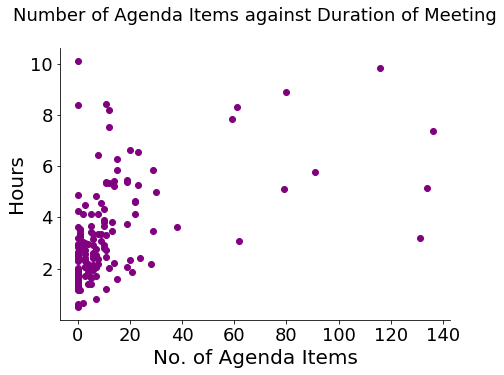

In [21]:
fig, ax = plt.subplots(figsize = (7,5))
plt.scatter(mpd["# Agenda Items"], mpd["Hours"], c = 'purple')
# plt.xticks(rotation=90)
plt.xlabel("No. of Agenda Items", fontsize=20)
plt.ylabel("Hours", fontsize=20)
plt.title("Number of Agenda Items against Duration of Meeting\n", fontsize=18)
plt.xticks(size=18)
plt.yticks(size=18)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# plt.savefig("DvsAI.pdf", bboxgrid="tight")
plt.show()

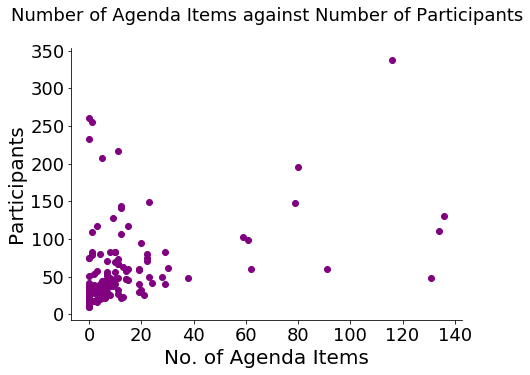

In [22]:
fig, ax = plt.subplots(figsize = (7,5))


plt.scatter(mpd["# Agenda Items"], mpd["Participants"], c= 'purple')
# plt.xticks(rotation=90)
plt.xlabel("No. of Agenda Items", fontsize=20)
plt.ylabel("Participants", fontsize=20)
plt.title("Number of Agenda Items against Number of Participants\n", fontsize=18)
plt.xticks(size=18)
plt.yticks(size=18)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# plt.savefig("PvsAI.pdf", bboxgrid="tight")
plt.show()

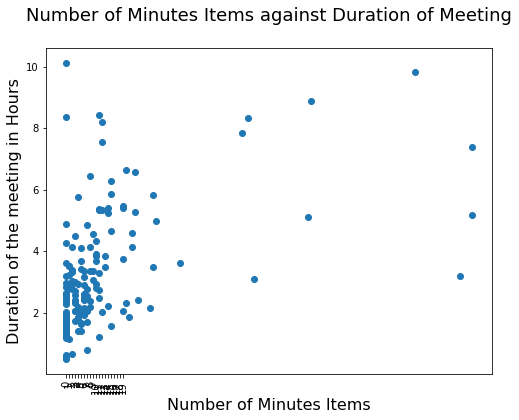

In [23]:
plt.scatter(mpd["# Minutes Items"], mpd["Hours"])
plt.xticks(range(0, 20), rotation=90)
plt.xlabel("Number of Minutes Items", fontsize=16)
plt.ylabel("Duration of the meeting in Hours", fontsize=16)
plt.title("Number of Minutes Items against Duration of Meeting\n", fontsize=18)
# plt.savefig("DvsMI.png", bboxgrid="tight")
plt.show()

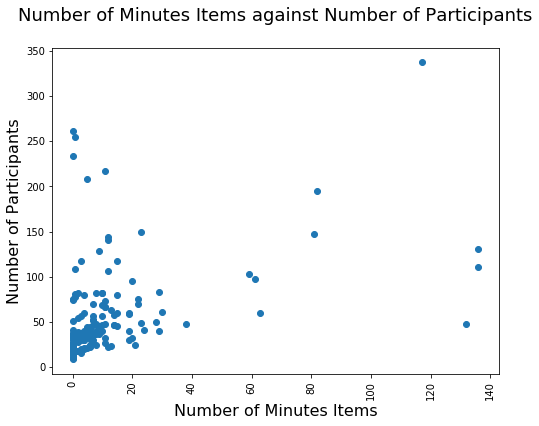

In [24]:
plt.scatter(mpd["# Minutes Items"], mpd["Participants"])
plt.xticks(rotation=90)
plt.xlabel("Number of Minutes Items", fontsize=16)
plt.ylabel("Number of Participants", fontsize=16)
plt.title("Number of Minutes Items against Number of Participants\n", fontsize=18)
# plt.savefig("PvsMI.png", bboxgrid="tight")
plt.show()

In [25]:
tc = mpd.groupby(mpd["Committee"]).sum()
tc

,Participants,# Agenda Items,# Minutes Items,Hours
Committee,,,,
Ad Hoc Task Force on the Structure of City Government (TFOGS) Final Report Implementation Work Group,42,10,9,3.716667
Affirmative Action Commission,25,8,8,2.183333
Alcohol License Review Committee,424,193,193,34.783333
Alder Workgroup to Develop Logistics and Operational Details for MPD Independent Civilian Oversight,484,66,66,26.550000
"Board of Building Code, Fire Code, Conveyance Code and Licensing Appeals",89,3,3,2.433333
Board of Park Commissioners,213,32,32,13.766667
Board of Public Works,214,131,131,16.266667
Body-Worn Camera Feasibility Review Committee,77,15,15,7.883333
CDA Board,30,7,7,0.800000


In [26]:
tc.index = ['TFOGS',
         'Affirmative Action Commission', 
         'Alcohol License Review Committee',
         'Alder Workgroup',
         'Board of Codes and Appeals',
         'Board of Park Commissioners', 
         'Board of Public Works',
         'Body-Worn Camera Feasibility Review Committee', 
         'CDA Board',
         'CDBG Committee', 
         'City-Wide Violence Meeting',
         'Common Council Executive Committee',
         'Community Development Authority Board',
         'Community Development Block Grant Committee',
         'Community Services Committee', 
         'Complete Count Committee',
         'Deferred Compensation Committee', 
         'Downtown Coordinating Committee',
         'Economic Development Committee', 
         'Equal Opportunities Commission',
         'Finance Committee', 
         'Food Policy Council',
         'Food Systems Recovery and Resilience Work Group',
         'Housing Strategy Committee', 
         'Landlord and Tenant Issues Committee',
         'Landmarks Commission', 
         'MATPB',
         'MLK Commission',
         'Madison Arts Commission',
         'Madison Food Policy Council',
         'Madison Public Library Board',
         'MTCCCB', 
         'PSRC',
         'Personnel Board', 
         'Plan Commission',
         'Communication Tools & Processes',
         'Public Safety Review Committee', 
         'Room Tax Commission',
         'Sustainable Madison Committee',
         'Task Force on Golf in Madison Parks',
         'Traffic Calming Subcommittee',
         'Transportation Commission',
         'Transportation Policy and Planning Board',
         'Urban Design Commission',
         'Water Utility Board',
         'Zoning Board of Appeals']

In [27]:
tcd = tc.sort_values(["# Agenda Items", "# Minutes Items"],ascending=False)
tcd

,Participants,# Agenda Items,# Minutes Items,Hours
Common Council Executive Committee,1531,889,813,76.966667
Alcohol License Review Committee,424,193,193,34.783333
Board of Public Works,214,131,131,16.266667
Finance Committee,394,117,117,23.616667
Plan Commission,1113,105,98,54.833333
Transportation Commission,216,72,72,21.533333
Alder Workgroup,484,66,66,26.550000
Urban Design Commission,597,35,35,29.100000
Board of Park Commissioners,213,32,32,13.766667
Water Utility Board,59,31,31,4.800000


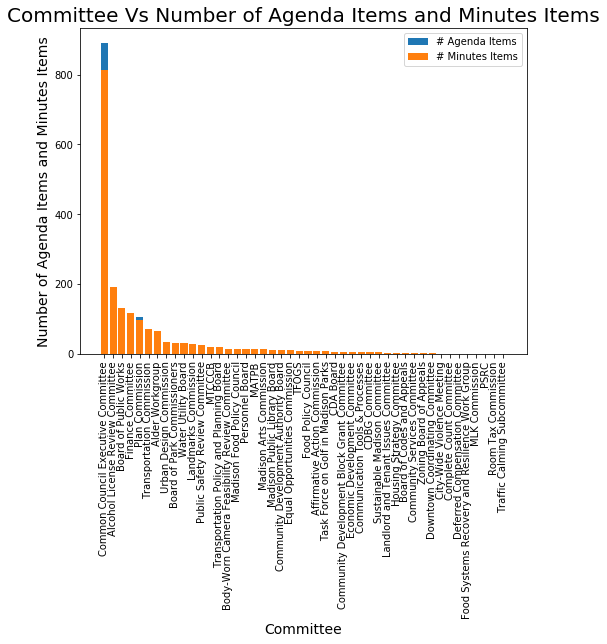

In [28]:
plt.bar(tcd.index, tcd["# Agenda Items"], label="# Agenda Items")
plt.bar(tcd.index, tcd["# Minutes Items"], label="# Minutes Items")
plt.legend()
plt.xticks(rotation=90)
plt.ylabel("Number of Agenda Items and Minutes Items", fontsize=14)
plt.xlabel("Committee", fontsize=14)
plt.title("Committee Vs Number of Agenda Items and Minutes Items", fontsize=20)
#plt.savefig("", bb)
plt.show()

In [29]:
tca = tc.sort_values(["# Agenda Items", "# Minutes Items"])
tca

,Participants,# Agenda Items,# Minutes Items,Hours
City-Wide Violence Meeting,19,0,0,1.183333
Complete Count Committee,18,0,0,1.683333
Deferred Compensation Committee,35,0,0,1.850000
Food Systems Recovery and Resilience Work Group,25,0,0,1.600000
MLK Commission,25,0,0,1.883333
PSRC,166,0,0,12.700000
Room Tax Commission,68,0,0,6.883333
Traffic Calming Subcommittee,35,0,0,2.650000
Downtown Coordinating Committee,18,1,2,3.383333
Zoning Board of Appeals,18,2,2,2.966667


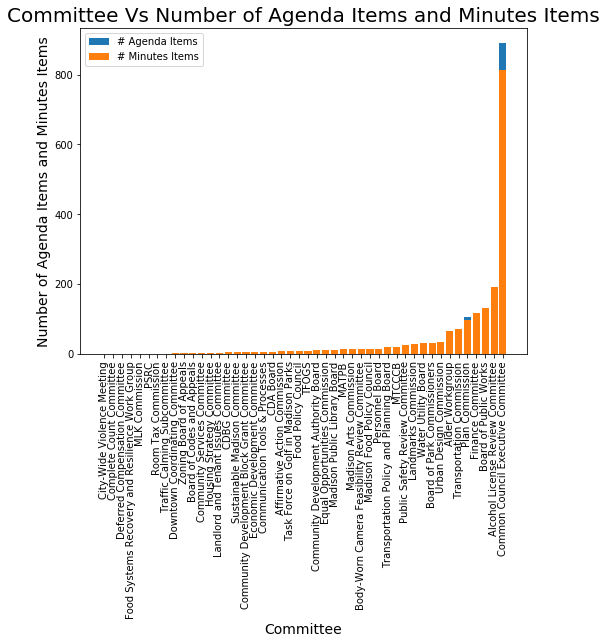

In [30]:
plt.bar(tca.index, tca["# Agenda Items"], label="# Agenda Items")
plt.bar(tca.index, tca["# Minutes Items"], label="# Minutes Items")
plt.legend()
plt.xticks(rotation=90)
plt.ylabel("Number of Agenda Items and Minutes Items", fontsize=14)
plt.xlabel("Committee", fontsize=14)
plt.title("Committee Vs Number of Agenda Items and Minutes Items", fontsize=20)
plt.show()

In [31]:
tm = mpd.groupby(mpd["Committee"]).mean()
tm

,Participants,# Agenda Items,# Minutes Items,Hours
Committee,,,,
Ad Hoc Task Force on the Structure of City Government (TFOGS) Final Report Implementation Work Group,21.000000,5.000000,4.500000,1.858333
Affirmative Action Commission,25.000000,8.000000,8.000000,2.183333
Alcohol License Review Committee,70.666667,32.166667,32.166667,5.797222
Alder Workgroup to Develop Logistics and Operational Details for MPD Independent Civilian Oversight,53.777778,7.333333,7.333333,2.950000
"Board of Building Code, Fire Code, Conveyance Code and Licensing Appeals",29.666667,1.000000,1.000000,0.811111
Board of Park Commissioners,71.000000,10.666667,10.666667,4.588889
Board of Public Works,35.666667,21.833333,21.833333,2.711111
Body-Worn Camera Feasibility Review Committee,25.666667,5.000000,5.000000,2.627778
CDA Board,30.000000,7.000000,7.000000,0.800000


In [32]:
tm.index = ['TFOGS',
         'Affirmative Action Commission', 
         'Alcohol License Review Committee',
         'Alder Workgroup',
         'Board of Codes and Appeals',
         'Board of Park Commissioners', 
         'Board of Public Works',
         'Body-Worn Camera Feasibility Review Committee', 
         'CDA Board',
         'CDBG Committee', 
         'City-Wide Violence Meeting',
         'Common Council Executive Committee',
         'Community Development Authority Board',
         'Community Development Block Grant Committee',
         'Community Services Committee', 
         'Complete Count Committee',
         'Deferred Compensation Committee', 
         'Downtown Coordinating Committee',
         'Economic Development Committee', 
         'Equal Opportunities Commission',
         'Finance Committee', 
         'Food Policy Council',
         'Food Systems Recovery and Resilience Work Group',
         'Housing Strategy Committee', 
         'Landlord and Tenant Issues Committee',
         'Landmarks Commission', 
         'MATPB',
         'MLK Commission',
         'Madison Arts Commission',
         'Madison Food Policy Council',
         'Madison Public Library Board',
         'MTCCCB', 
         'PSRC',
         'Personnel Board', 
         'Plan Commission',
         'Communication Tools & Processes',
         'Public Safety Review Committee', 
         'Room Tax Commission',
         'Sustainable Madison Committee',
         'Task Force on Golf in Madison Parks',
         'Traffic Calming Subcommittee',
         'Transportation Commission',
         'Transportation Policy and Planning Board',
         'Urban Design Commission',
         'Water Utility Board',
         'Zoning Board of Appeals']

In [33]:
tmd = tm.sort_values(["# Agenda Items", "# Minutes Items"],ascending=False)
tmd

,Participants,# Agenda Items,# Minutes Items,Hours
Common Council Executive Committee,72.904762,42.333333,38.714286,3.665079
Alcohol License Review Committee,70.666667,32.166667,32.166667,5.797222
Board of Public Works,35.666667,21.833333,21.833333,2.711111
Transportation Commission,54.000000,18.000000,18.000000,5.383333
Finance Committee,56.285714,16.714286,16.714286,3.373810
Water Utility Board,29.500000,15.500000,15.500000,2.400000
Personnel Board,60.000000,15.000000,15.000000,1.583333
Madison Arts Commission,47.000000,14.000000,14.000000,2.233333
Plan Commission,123.666667,11.666667,10.888889,6.092593
Community Development Authority Board,32.000000,11.000000,11.000000,1.216667


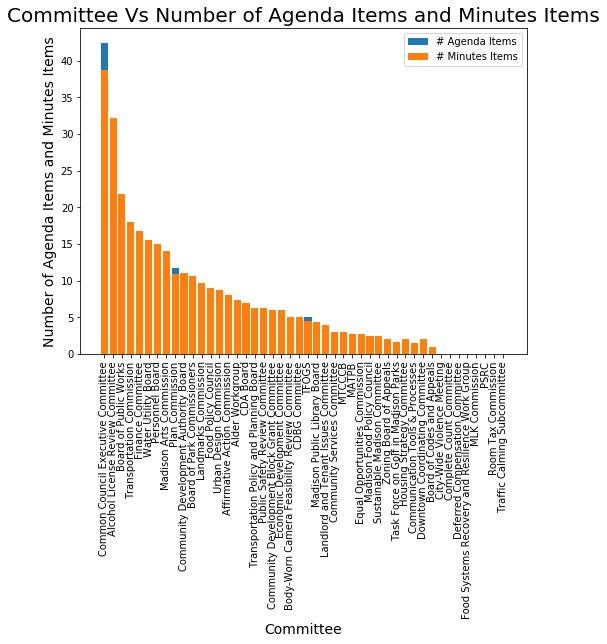

In [34]:
plt.bar(tmd.index, tmd["# Agenda Items"], label="# Agenda Items")
plt.bar(tmd.index, tmd["# Minutes Items"], label="# Minutes Items")
#plt.bar(tmd.index, tmd["Hours"], label="Duration in Hours")
plt.legend()
plt.xticks(rotation=90)
plt.ylabel("Number of Agenda Items and Minutes Items", fontsize=14)
plt.xlabel("Committee", fontsize=14)
plt.title("Committee Vs Number of Agenda Items and Minutes Items", fontsize=20)
# plt.savefig("CAMItems.png", bbox_inches = "tight")
plt.show()

In [35]:
tma = tm.sort_values(["# Agenda Items", "# Minutes Items"])
tma

,Participants,# Agenda Items,# Minutes Items,Hours
City-Wide Violence Meeting,19.000000,0.000000,0.000000,1.183333
Complete Count Committee,18.000000,0.000000,0.000000,1.683333
Deferred Compensation Committee,35.000000,0.000000,0.000000,1.850000
Food Systems Recovery and Resilience Work Group,25.000000,0.000000,0.000000,1.600000
MLK Commission,25.000000,0.000000,0.000000,1.883333
PSRC,27.666667,0.000000,0.000000,2.116667
Room Tax Commission,34.000000,0.000000,0.000000,3.441667
Traffic Calming Subcommittee,17.500000,0.000000,0.000000,1.325000
Board of Codes and Appeals,29.666667,1.000000,1.000000,0.811111
Downtown Coordinating Committee,18.000000,1.000000,2.000000,3.383333


In [47]:
# plt.bar(tma.index, tma["# Agenda Items"], label="# Agenda Items")
# plt.bar(tma.index, tma["# Minutes Items"], label="# Minutes Items")
# plt.legend()
# plt.xticks(rotation=90)
# plt.ylabel("Number of Agenda Items and Minutes Items", fontsize=14)
# plt.xlabel("Committee", fontsize=14)
# plt.title("Committee Vs Number of Agenda Items and Minutes Items", fontsize=20)
# plt.tight_layout()
# plt.show()

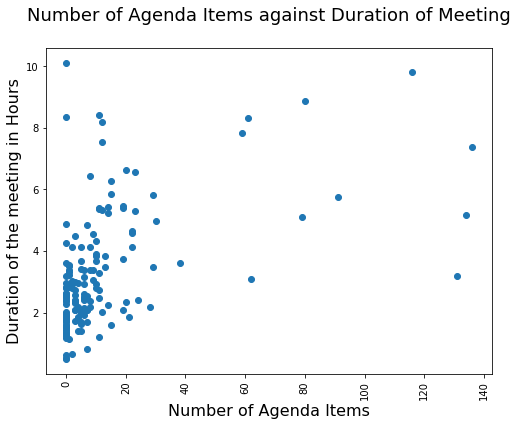

In [48]:
plt.scatter(mpd["# Agenda Items"], mpd["Hours"])
plt.xticks(rotation=90)
plt.xlabel("Number of Agenda Items", fontsize=16)
plt.ylabel("Duration of the meeting in Hours", fontsize=16)
plt.title("Number of Agenda Items against Duration of Meeting\n", fontsize=18)
plt.savefig("DvsAI.png", bboxgrid="tight")
plt.show()

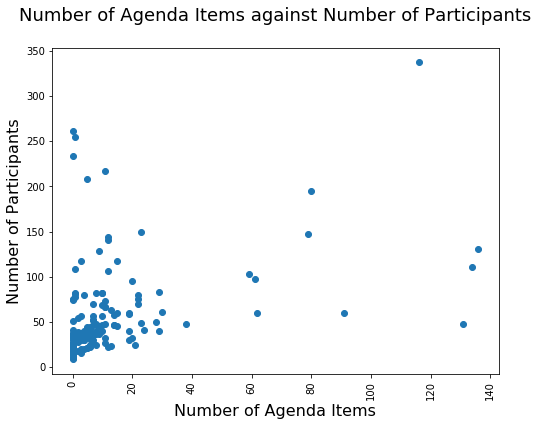

In [36]:
plt.scatter(mpd["# Agenda Items"], mpd["Participants"])
plt.xticks(rotation=90)
plt.xlabel("Number of Agenda Items", fontsize=16)
plt.ylabel("Number of Participants", fontsize=16)
plt.title("Number of Agenda Items against Number of Participants\n", fontsize=18)
# plt.savefig("PvsAI.png", bboxgrid="tight")
plt.show()

In [37]:
x = mpd["# Agenda Items"]
q1_x = x.quantile(.25) 
q3_x = x.quantile(.75) 
iqr_x = q3_x - q1_x
print(q1_x, q3_x, iqr_x)
print(q1_x - (1.5*iqr_x), q3_x + (1.5*iqr_x))
oai = x[x.between(q1_x - (1.5*iqr_x), q3_x + (1.5*iqr_x))] # without outliers
oai

0.0 12.0 12.0
-18.0 30.0


0       7
2       6
3       0
4      22
5      11
       ..
150     0
151     2
152     6
153     1
154     0
Name: # Agenda Items, Length: 144, dtype: int64

In [38]:
set(mpd.index) - set(oai.index)

{1, 8, 9, 10, 16, 28, 38, 57, 60, 115, 130}

In [39]:
age = mpd[mpd["# Agenda Items"] > 31][["Committee", "Participants", "Duration", "# Agenda Items"]]
age

,Committee,Participants,Duration,# Agenda Items
1,Common Council Executive Committee,337,9:48:36,116
8,Common Council Executive Committee,60,5:45:23,91
9,Board of Public Works,48,3:37:43,38
10,Alcohol License Review Committee,98,8:19:16,61
16,Common Council Executive Committee,48,3:10:54,131
28,Common Council Executive Committee,60,3:06:22,62
38,Common Council Executive Committee,131,7:22:20,136
57,Common Council Executive Committee,147,5:06:44,79
60,Alcohol License Review Committee,103,7:49:45,59
115,Common Council Executive Committee,111,5:09:50,134


In [40]:
render_mpl_table(age, header_columns=0, col_width=6)
plt.savefig("a_outliers.png")

NameError: name 'render_mpl_table' is not defined

In [41]:
mpd.iloc[1]

Meeting_ID                                                       531 697 510
Topic                                                         Common Council
Scheduled_Start_Time                                              6:30:00 PM
Zoom_Meeting_Start_Time                                  2020-03-31 17:04:00
Zoom_Meeting_End_Time                                    2020-04-01 02:53:00
Duration                                                             9:48:36
Participants                                                             337
Recording                                                                Yes
Agenda_Link                https://madison.legistar.com/View.ashx?M=A&ID=...
Minutes_Link               https://madison.legistar.com/View.ashx?M=M&ID=...
Start_Date                                                         3/31/2020
Start_Time                                                             17:04
Meeting_Duration                                             0 days 09:49:00

In [42]:
#print(oai.index.values)
mpdri = mpd.take(oai.index.values)
mpdri

,Meeting_ID,Topic,Scheduled_Start_Time,Zoom_Meeting_Start_Time,Zoom_Meeting_End_Time,Duration,Participants,Recording,Agenda_Link,Minutes_Link,...,Start_Time,Meeting_Duration,Committee,Agenda HTML,Minutes HTML,Agenda Items,Minutes Items,# Agenda Items,# Minutes Items,Hours
0,954 410 442,CCEC,4:30:00 PM,2020-03-31 15:40:00,2020-03-31 18:27:00,2:47:55,52,Yes,https://madison.legistar.com/View.ashx?M=A&ID=...,https://madison.legistar.com/View.ashx?M=M&ID=...,...,15:40,02:47:00,Common Council Executive Committee,"[[[\n, <meta content=""text/html; charset=utf-8...","[[[\n, <meta content=""text/html; charset=utf-8...",{59845: 'Establishing a Body-Worn Camera Feasi...,{59845: 'Establishing a Body-Worn Camera Feasi...,7,7,2.783333
2,411 578 576,"Finance Committee: Meeting of April 6, 2020",4:30:00 PM,2020-04-06 15:40:00,2020-04-06 17:49:00,2:09:00,31,Yes,https://madison.legistar.com/View.ashx?M=A&ID=...,https://madison.legistar.com/View.ashx?M=M&ID=...,...,15:40,02:09:00,Finance Committee,"[[[\n, <meta content=""text/html; charset=utf-8...","[[[\n, <meta content=""text/html; charset=utf-8...",{60005: 'A Resolution to authorize the noncomp...,{60005: 'A Resolution to authorize the noncomp...,6,6,2.150000
3,563 608 269,"CCEC: Meeting of April 9, 2020",6:00:00 PM,2020-04-09 16:57:00,2020-04-09 19:53:00,2:56:08,36,Yes,https://madison.legistar.com/View.ashx?M=A&ID=...,https://madison.legistar.com/View.ashx?M=M&ID=...,...,16:57,02:56:00,Common Council Executive Committee,"[[[\n, <meta content=""text/html; charset=utf-8...","[[[\n, <meta content=""text/html; charset=utf-8...",{},{60110: 'Discuss Council's Role & Response dur...,0,2,2.933333
4,468 948 855,"Plan Commission: Meeting of April 13, 2020",5:30:00 PM,2020-04-13 16:35:00,2020-04-13 21:14:00,4:38:54,80,Yes,https://madison.legistar.com/View.ashx?M=A&ID=...,https://madison.legistar.com/View.ashx?M=M&ID=...,...,16:35,04:39:00,Plan Commission,"[[[\n, <meta content=""text/html; charset=utf-8...","[[[\n, <meta content=""text/html; charset=utf-8...",{60134: 'General Public Correspondence to the ...,{60182: 'Recommendation of Fire Chief regardin...,22,15,4.650000
5,215 073 411,Transportation Commission: Meeting of April 15...,5:00:00 PM,2020-04-15 16:26:00,2020-04-15 21:49:00,5:22:28,67,Yes,https://madison.legistar.com/View.ashx?M=A&ID=...,https://madison.legistar.com/View.ashx?M=M&ID=...,...,16:26,05:23:00,Transportation Commission,"[[[\n, <meta content=""text/html; charset=utf-8...","[[[\n, <meta content=""text/html; charset=utf-8...",{60179: 'Report on the actions taken by the Tr...,{60179: 'Report on the actions taken by the Tr...,11,11,5.383333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,934 9101 4777,Public Safety Review Committee Budget Subcommi...,NaN,2020-07-29 17:46:00,2020-07-29 20:17:00,2:30:50,21,Yes,NaN,NaN,...,17:46,02:31:00,Public Safety Review Committee,,,{},{},0,0,2.516667
151,985 6384 8547,"Plan Commission: Meeting of July 30, 2020",5:00:00 PM,2020-07-30 15:58:00,2020-07-30 20:06:00,4:08:29,54,Yes,https://madison.legistar.com/View.ashx?M=A&ID=...,https://madison.legistar.com/View.ashx?M=M&ID=...,...,15:58,04:08:00,Plan Commission,"[[[\n, <meta content=""text/html; charset=utf-8...","[[[\n, <meta content=""text/html; charset=utf-8...",{60306: 'Plan Commission Public Comment Period...,{60306: 'Plan Commission Public Comment Period...,2,2,4.133333
152,998 8578 7121,Body-Worn Camera Feasibility Review Committee:...,5:30:00 PM,2020-07-30 17:06:00,2020-07-30 19:35:00,2:28:11,23,Yes,https://madison.legistar.com/View.ashx?M=A&ID=...,https://madison.legistar.com/View.ashx?M=M&ID=...,...,17:06,02:29:00,Body-Worn Camera Feasibility Review Committee,"[[[\n, <meta content=""text/html; charset=utf-8...","[[[\n, <meta content=""text/html; charset=utf-8...",{61546: 'PUBLIC COMMENT FOR THE 7/30/2020 MEET...,{61546: 'PUBLIC COMMENT FOR THE 7/30/2020 MEET...,6,6,2.483333
153,949 7219 5424,Task Force on Municipal Golf in Madison Parks:...,6:00:00 P

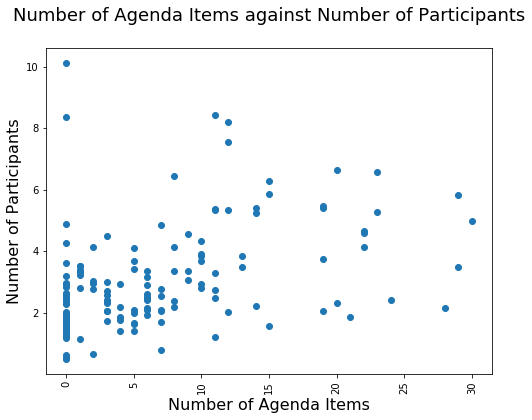

In [43]:
plt.scatter(mpdri["# Agenda Items"], mpdri["Hours"])
plt.xticks(rotation=90)
plt.xlabel("Number of Agenda Items", fontsize=16)
plt.ylabel("Number of Participants", fontsize=16)
plt.title("Number of Agenda Items against Number of Participants\n", fontsize=18)
# plt.savefig("PvsAI.png", bboxgrid="tight")
plt.show()

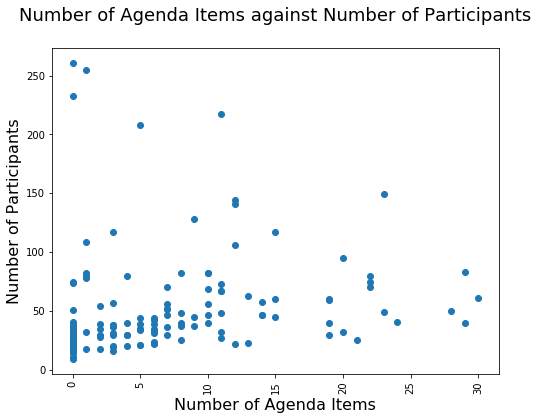

In [44]:
plt.scatter(mpdri["# Agenda Items"], mpdri["Participants"])
plt.xticks(rotation=90)
plt.xlabel("Number of Agenda Items", fontsize=16)
plt.ylabel("Number of Participants", fontsize=16)
plt.title("Number of Agenda Items against Number of Participants\n", fontsize=18)
# plt.savefig("PvsAI.png", bboxgrid="tight")
plt.show()

In [45]:
mpdri = mpdri.reset_index()

In [46]:
y = mpdri["Participants"]
q1_y = y.quantile(.25) 
q3_y = y.quantile(.75) 
iqr_y = q3_y - q1_y
print(q1_y, q3_y, iqr_y)
print(q1_y - (1.5*iqr_y), q3_y + (1.5*iqr_y))
op = y[y.between(q1_y - (1.5*iqr_y), q3_y + (1.5*iqr_y))] # without outliers
op

24.75 59.25 34.5
-27.0 111.0


0      52
1      31
2      36
3      80
4      67
       ..
139    21
140    54
141    23
142    81
143    35
Name: Participants, Length: 133, dtype: int64

In [47]:
set(mpdri.index) - set(op.index)

{9, 14, 20, 27, 42, 58, 68, 76, 80, 96, 102}

In [48]:
ag = mpdri[mpdri.Participants > 111][["Committee", "Participants", "Duration", "# Agenda Items"]]
ag

,Committee,Participants,Duration,# Agenda Items
9,Urban Design Commission,149,6:33:32,23
14,Plan Commission,261,8:22:07,0
20,Plan Commission,217,8:26:40,11
27,Urban Design Commission,141,7:31:43,12
42,Board of Park Commissioners,128,4:33:16,9
58,Sustainable Madison Committee,117,4:30:02,3
68,Plan Commission,144,8:12:36,12
76,Urban Design Commission,233,10:06:54,0
80,Madison Public Library Board,208,4:07:08,5
96,Madison Public Library Board,255,3:30:37,1


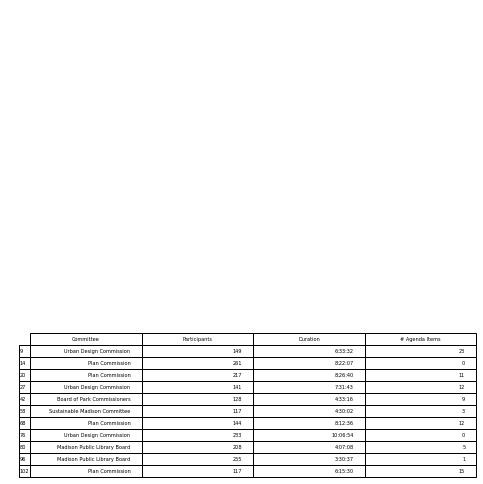

In [49]:
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import table # EDIT: see deprecation warnings below

ax = plt.subplot(111, frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis

table(ax, ag)  # where df is your data frame

# plt.savefig('agendaoutliers.png', bboxgrid="tight")

In [50]:
import six
def render_mpl_table(data, col_width=5.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax

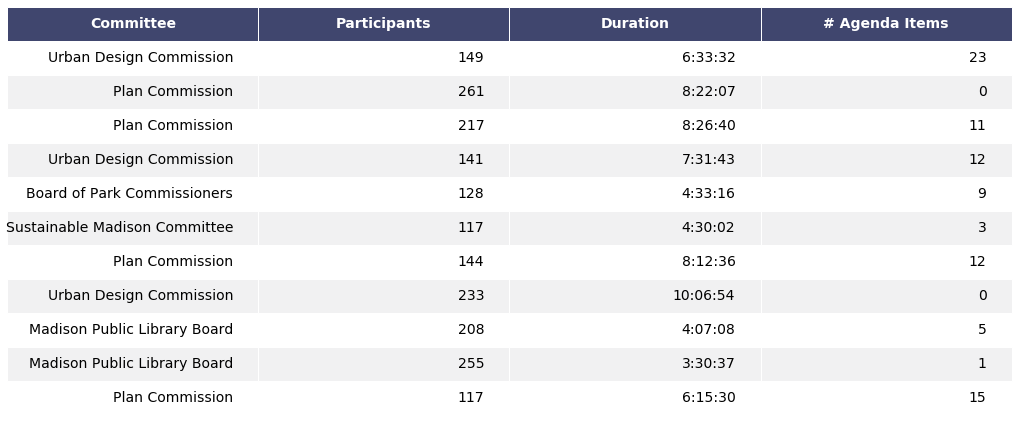

In [51]:
render_mpl_table(ag, header_columns=0, col_width=4.5)
# plt.savefig("p_outliers.png")

In [52]:
#print(op.index.values)
mpdrip = mpdri.take(op.index.values)
mpdrip

,index,Meeting_ID,Topic,Scheduled_Start_Time,Zoom_Meeting_Start_Time,Zoom_Meeting_End_Time,Duration,Participants,Recording,Agenda_Link,...,Start_Time,Meeting_Duration,Committee,Agenda HTML,Minutes HTML,Agenda Items,Minutes Items,# Agenda Items,# Minutes Items,Hours
0,0,954 410 442,CCEC,4:30:00 PM,2020-03-31 15:40:00,2020-03-31 18:27:00,2:47:55,52,Yes,https://madison.legistar.com/View.ashx?M=A&ID=...,...,15:40,02:47:00,Common Council Executive Committee,"[[[\n, <meta content=""text/html; charset=utf-8...","[[[\n, <meta content=""text/html; charset=utf-8...",{59845: 'Establishing a Body-Worn Camera Feasi...,{59845: 'Establishing a Body-Worn Camera Feasi...,7,7,2.783333
1,2,411 578 576,"Finance Committee: Meeting of April 6, 2020",4:30:00 PM,2020-04-06 15:40:00,2020-04-06 17:49:00,2:09:00,31,Yes,https://madison.legistar.com/View.ashx?M=A&ID=...,...,15:40,02:09:00,Finance Committee,"[[[\n, <meta content=""text/html; charset=utf-8...","[[[\n, <meta content=""text/html; charset=utf-8...",{60005: 'A Resolution to authorize the noncomp...,{60005: 'A Resolution to authorize the noncomp...,6,6,2.150000
2,3,563 608 269,"CCEC: Meeting of April 9, 2020",6:00:00 PM,2020-04-09 16:57:00,2020-04-09 19:53:00,2:56:08,36,Yes,https://madison.legistar.com/View.ashx?M=A&ID=...,...,16:57,02:56:00,Common Council Executive Committee,"[[[\n, <meta content=""text/html; charset=utf-8...","[[[\n, <meta content=""text/html; charset=utf-8...",{},{60110: 'Discuss Council's Role & Response dur...,0,2,2.933333
3,4,468 948 855,"Plan Commission: Meeting of April 13, 2020",5:30:00 PM,2020-04-13 16:35:00,2020-04-13 21:14:00,4:38:54,80,Yes,https://madison.legistar.com/View.ashx?M=A&ID=...,...,16:35,04:39:00,Plan Commission,"[[[\n, <meta content=""text/html; charset=utf-8...","[[[\n, <meta content=""text/html; charset=utf-8...",{60134: 'General Public Correspondence to the ...,{60182: 'Recommendation of Fire Chief regardin...,22,15,4.650000
4,5,215 073 411,Transportation Commission: Meeting of April 15...,5:00:00 PM,2020-04-15 16:26:00,2020-04-15 21:49:00,5:22:28,67,Yes,https://madison.legistar.com/View.ashx?M=A&ID=...,...,16:26,05:23:00,Transportation Commission,"[[[\n, <meta content=""text/html; charset=utf-8...","[[[\n, <meta content=""text/html; charset=utf-8...",{60179: 'Report on the actions taken by the Tr...,{60179: 'Report on the actions taken by the Tr...,11,11,5.383333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,150,934 9101 4777,Public Safety Review Committee Budget Subcommi...,NaN,2020-07-29 17:46:00,2020-07-29 20:17:00,2:30:50,21,Yes,NaN,...,17:46,02:31:00,Public Safety Review Committee,,,{},{},0,0,2.516667
140,151,985 6384 8547,"Plan Commission: Meeting of July 30, 2020",5:00:00 PM,2020-07-30 15:58:00,2020-07-30 20:06:00,4:08:29,54,Yes,https://madison.legistar.com/View.ashx?M=A&ID=...,...,15:58,04:08:00,Plan Commission,"[[[\n, <meta content=""text/html; charset=utf-8...","[[[\n, <meta content=""text/html; charset=utf-8...",{60306: 'Plan Commission Public Comment Period...,{60306: 'Plan Commission Public Comment Period...,2,2,4.133333
141,152,998 8578 7121,Body-Worn Camera Feasibility Review Committee:...,5:30:00 PM,2020-07-30 17:06:00,2020-07-30 19:35:00,2:28:11,23,Yes,https://madison.legistar.com/View.ashx?M=A&ID=...,...,17:06,02:29:00,Body-Worn Camera Feasibility Review Committee,"[[[\n, <meta content=""text/html; charset=utf-8...","[[[\n, <meta content=""text/html; charset=utf-8...",{61546: 'PUBLIC COMMENT FOR THE 7/30/2020 MEET...,{61546: 'PUBLIC COMMENT FOR THE 7/30/2020 MEET...,6,6,2.483333
142,153,949 7219 5424,Task Force on Municipal Golf in Madison Parks:...,6:00:00 PM,2020-07-30 17:35:00,2020-07-30 20:24:00,2:49:27,81,Yes,https://madison.legistar.com/View.ashx?M=A&ID=...,...,17:35,02:49:00,Task Force on Golf in Madison Parks,"[[[\n, <meta content=""text/html; charset=utf-8...","[[[\n, <meta content=""text/html; charset=utf-8...","{59227: 'Task Force Deliberation, Discussion, ...","{59227: 'Task 

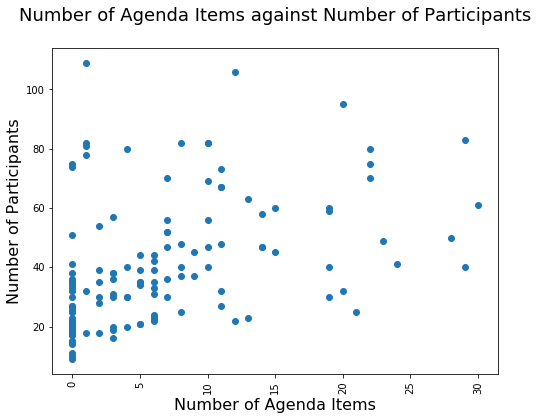

In [53]:
plt.scatter(mpdrip["# Agenda Items"], mpdrip["Participants"])
plt.xticks(rotation=90)
plt.xlabel("Number of Agenda Items", fontsize=16)
plt.ylabel("Number of Participants", fontsize=16)
plt.title("Number of Agenda Items against Number of Participants\n", fontsize=18)
# plt.savefig("PvsAI2.png", bboxgrid="tight")
plt.show()

In [54]:
y = mpdri["Hours"]
q1_y = y.quantile(.25) 
q3_y = y.quantile(.75) 
iqr_y = q3_y - q1_y
print(q1_y, q3_y, iqr_y)
print(q1_y - (1.5*iqr_y), q3_y + (1.5*iqr_y))
oh = y[y.between(q1_y - (1.5*iqr_y), q3_y + (1.5*iqr_y))] # without outliers
oh

1.9208333333333334 3.6999999999999997 1.7791666666666663
-0.7479166666666659 6.368749999999999


0      2.783333
1      2.150000
2      2.933333
3      4.650000
4      5.383333
         ...   
139    2.516667
140    4.133333
141    2.483333
142    2.816667
143    1.850000
Name: Hours, Length: 136, dtype: float64

In [55]:
set(mpdri.index) - set(oh.index)

{9, 14, 20, 27, 31, 68, 76, 132}

In [56]:
ho = mpdri[mpdri.Hours > 6.4][["Committee", "Participants", "Duration", "# Agenda Items"]]
ho

,Committee,Participants,Duration,# Agenda Items
9,Urban Design Commission,149,6:33:32,23
14,Plan Commission,261,8:22:07,0
20,Plan Commission,217,8:26:40,11
27,Urban Design Commission,141,7:31:43,12
31,Landmarks Commission,48,6:26:31,8
68,Plan Commission,144,8:12:36,12
76,Urban Design Commission,233,10:06:54,0
132,Plan Commission,95,6:38:14,20


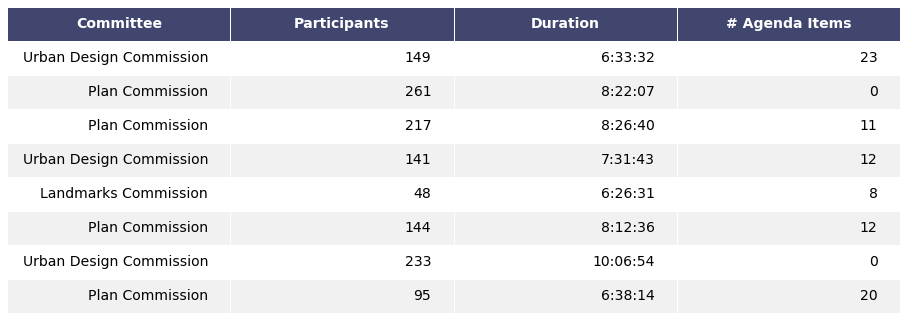

In [57]:
render_mpl_table(ho, header_columns=0, col_width=4)
plt.savefig("h_outliers.png")

In [58]:
mpdri.iloc[9]

index                                                                     13
Meeting_ID                                                       533 380 868
Topic                                                Urban Design Commission
Scheduled_Start_Time                                              4:30:00 PM
Zoom_Meeting_Start_Time                                  2020-04-29 15:29:00
Zoom_Meeting_End_Time                                    2020-04-29 22:03:00
Duration                                                             6:33:32
Participants                                                             149
Recording                                                                Yes
Agenda_Link                https://madison.legistar.com/View.ashx?M=A&ID=...
Minutes_Link               https://madison.legistar.com/View.ashx?M=M&ID=...
Start_Date                                                         4/29/2020
Start_Time                                                             15:29

In [59]:
set(mpdri.index) - set(oh.index), set(mpdri.index) - set(op.index)

({9, 14, 20, 27, 31, 68, 76, 132},
 {9, 14, 20, 27, 42, 58, 68, 76, 80, 96, 102})

In [60]:
#print(op.index.values)
mpdrih = mpdri.take(oh.index.values)
mpdrih

,index,Meeting_ID,Topic,Scheduled_Start_Time,Zoom_Meeting_Start_Time,Zoom_Meeting_End_Time,Duration,Participants,Recording,Agenda_Link,...,Start_Time,Meeting_Duration,Committee,Agenda HTML,Minutes HTML,Agenda Items,Minutes Items,# Agenda Items,# Minutes Items,Hours
0,0,954 410 442,CCEC,4:30:00 PM,2020-03-31 15:40:00,2020-03-31 18:27:00,2:47:55,52,Yes,https://madison.legistar.com/View.ashx?M=A&ID=...,...,15:40,02:47:00,Common Council Executive Committee,"[[[\n, <meta content=""text/html; charset=utf-8...","[[[\n, <meta content=""text/html; charset=utf-8...",{59845: 'Establishing a Body-Worn Camera Feasi...,{59845: 'Establishing a Body-Worn Camera Feasi...,7,7,2.783333
1,2,411 578 576,"Finance Committee: Meeting of April 6, 2020",4:30:00 PM,2020-04-06 15:40:00,2020-04-06 17:49:00,2:09:00,31,Yes,https://madison.legistar.com/View.ashx?M=A&ID=...,...,15:40,02:09:00,Finance Committee,"[[[\n, <meta content=""text/html; charset=utf-8...","[[[\n, <meta content=""text/html; charset=utf-8...",{60005: 'A Resolution to authorize the noncomp...,{60005: 'A Resolution to authorize the noncomp...,6,6,2.150000
2,3,563 608 269,"CCEC: Meeting of April 9, 2020",6:00:00 PM,2020-04-09 16:57:00,2020-04-09 19:53:00,2:56:08,36,Yes,https://madison.legistar.com/View.ashx?M=A&ID=...,...,16:57,02:56:00,Common Council Executive Committee,"[[[\n, <meta content=""text/html; charset=utf-8...","[[[\n, <meta content=""text/html; charset=utf-8...",{},{60110: 'Discuss Council's Role & Response dur...,0,2,2.933333
3,4,468 948 855,"Plan Commission: Meeting of April 13, 2020",5:30:00 PM,2020-04-13 16:35:00,2020-04-13 21:14:00,4:38:54,80,Yes,https://madison.legistar.com/View.ashx?M=A&ID=...,...,16:35,04:39:00,Plan Commission,"[[[\n, <meta content=""text/html; charset=utf-8...","[[[\n, <meta content=""text/html; charset=utf-8...",{60134: 'General Public Correspondence to the ...,{60182: 'Recommendation of Fire Chief regardin...,22,15,4.650000
4,5,215 073 411,Transportation Commission: Meeting of April 15...,5:00:00 PM,2020-04-15 16:26:00,2020-04-15 21:49:00,5:22:28,67,Yes,https://madison.legistar.com/View.ashx?M=A&ID=...,...,16:26,05:23:00,Transportation Commission,"[[[\n, <meta content=""text/html; charset=utf-8...","[[[\n, <meta content=""text/html; charset=utf-8...",{60179: 'Report on the actions taken by the Tr...,{60179: 'Report on the actions taken by the Tr...,11,11,5.383333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,150,934 9101 4777,Public Safety Review Committee Budget Subcommi...,NaN,2020-07-29 17:46:00,2020-07-29 20:17:00,2:30:50,21,Yes,NaN,...,17:46,02:31:00,Public Safety Review Committee,,,{},{},0,0,2.516667
140,151,985 6384 8547,"Plan Commission: Meeting of July 30, 2020",5:00:00 PM,2020-07-30 15:58:00,2020-07-30 20:06:00,4:08:29,54,Yes,https://madison.legistar.com/View.ashx?M=A&ID=...,...,15:58,04:08:00,Plan Commission,"[[[\n, <meta content=""text/html; charset=utf-8...","[[[\n, <meta content=""text/html; charset=utf-8...",{60306: 'Plan Commission Public Comment Period...,{60306: 'Plan Commission Public Comment Period...,2,2,4.133333
141,152,998 8578 7121,Body-Worn Camera Feasibility Review Committee:...,5:30:00 PM,2020-07-30 17:06:00,2020-07-30 19:35:00,2:28:11,23,Yes,https://madison.legistar.com/View.ashx?M=A&ID=...,...,17:06,02:29:00,Body-Worn Camera Feasibility Review Committee,"[[[\n, <meta content=""text/html; charset=utf-8...","[[[\n, <meta content=""text/html; charset=utf-8...",{61546: 'PUBLIC COMMENT FOR THE 7/30/2020 MEET...,{61546: 'PUBLIC COMMENT FOR THE 7/30/2020 MEET...,6,6,2.483333
142,153,949 7219 5424,Task Force on Municipal Golf in Madison Parks:...,6:00:00 PM,2020-07-30 17:35:00,2020-07-30 20:24:00,2:49:27,81,Yes,https://madison.legistar.com/View.ashx?M=A&ID=...,...,17:35,02:49:00,Task Force on Golf in Madison Parks,"[[[\n, <meta content=""text/html; charset=utf-8...","[[[\n, <meta content=""text/html; charset=utf-8...","{59227: 'Task Force Deliberation, Discussion, ...","{59227: 'Task 

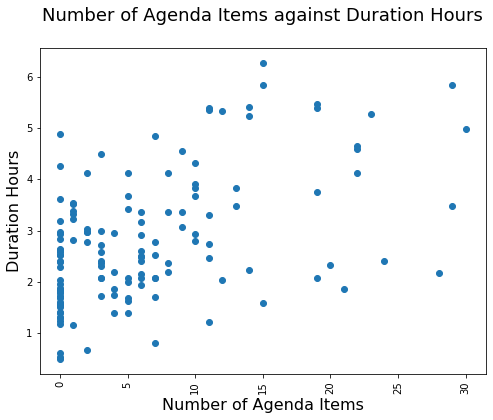

In [61]:
plt.scatter(mpdrih["# Agenda Items"], mpdrih["Hours"])
plt.xticks(rotation=90)
plt.xlabel("Number of Agenda Items", fontsize=16)
plt.ylabel("Duration Hours", fontsize=16)
plt.title("Number of Agenda Items against Duration Hours\n", fontsize=18)
# plt.savefig("DvsAI2.png", bboxgrid="tight")
plt.show()

In [62]:
ih1 = np.polyfit(mpdrih["# Agenda Items"], mpdrih["Hours"], 1, rcond=None, full=False)
ih1

array([0.08592424, 2.2401063 ])

In [63]:
eh1 = np.sum((np.polyval(np.polyfit(mpdrih["# Agenda Items"], mpdrih["Hours"], 1), mpdrih["# Agenda Items"]) - mpdrih["Hours"])**2)
eh1/len(mpdrih["# Agenda Items"])

1.1841009197151502

In [64]:
ih2 = np.polyfit(mpdrih["# Agenda Items"], mpdrih["Hours"], 2, rcond=None, full=False)
ih2

array([-0.00246175,  0.14230484,  2.10858782])

In [65]:
eh2 = np.sum((np.polyval(np.polyfit(mpdrih["# Agenda Items"], mpdrih["Hours"], 2), mpdrih["# Agenda Items"]) - mpdrih["Hours"])**2)
eh2/len(mpdrih["# Agenda Items"])

1.1589962659881379

In [66]:
ih3 = np.polyfit(mpdrih["# Agenda Items"], mpdrih["Hours"], 3, rcond=None, full=False)
ih3

array([-1.02751352e-04,  1.47850497e-03,  1.08449804e-01,  2.14138220e+00])

In [67]:
eh3 = np.sum((np.polyval(np.polyfit(mpdrih["# Agenda Items"], mpdrih["Hours"], 3), mpdrih["# Agenda Items"]) - mpdrih["Hours"])**2)
eh3/len(mpdrih["# Agenda Items"])

1.1563096819271177

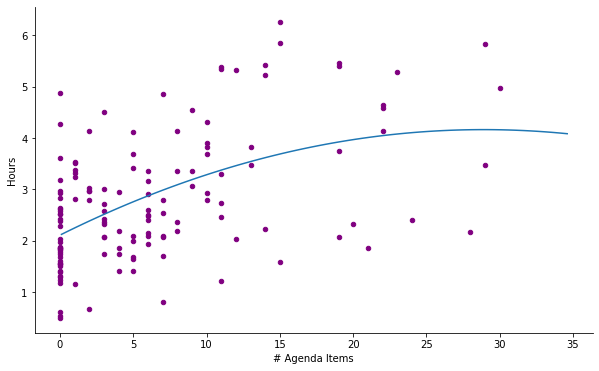

In [68]:
fig, ax = plt.subplots(figsize = (10,6))
mpdrih.plot.scatter(y='Hours', x="# Agenda Items", ax=ax, color='purple')
x = np.arange(0.1, 35, 0.5)
trendpoly = np.poly1d(ih2) 
plt.plot(x,trendpoly(x))
#plt.plot(X, lr.predict(get_xterms(x)), color='r')
#ax.set_ylabel("Average Meeting Duration in Hours", fontsize=16)
#ax.set_xlabel("Average Number of Meeting Participants", fontsize=16)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.set_title('Average Number of Participants by \nAverage Meeting Duration in Hours for each Committee\n', fontsize=20)
#plt.savefig("PvsD2.png", bbox_inches = "tight")
None

**TERRYS FITTING DATA START - HOURS VS. AGENDA**

In [69]:
mpdrih.head(2)

,index,Meeting_ID,Topic,Scheduled_Start_Time,Zoom_Meeting_Start_Time,Zoom_Meeting_End_Time,Duration,Participants,Recording,Agenda_Link,...,Start_Time,Meeting_Duration,Committee,Agenda HTML,Minutes HTML,Agenda Items,Minutes Items,# Agenda Items,# Minutes Items,Hours
0,0,954 410 442,CCEC,4:30:00 PM,2020-03-31 15:40:00,2020-03-31 18:27:00,2:47:55,52,Yes,https://madison.legistar.com/View.ashx?M=A&ID=...,...,15:40,02:47:00,Common Council Executive Committee,"[[[\n, <meta content=""text/html; charset=utf-8...","[[[\n, <meta content=""text/html; charset=utf-8...",{59845: 'Establishing a Body-Worn Camera Feasi...,{59845: 'Establishing a Body-Worn Camera Feasi...,7,7,2.783333
1,2,411 578 576,"Finance Committee: Meeting of April 6, 2020",4:30:00 PM,2020-04-06 15:40:00,2020-04-06 17:49:00,2:09:00,31,Yes,https://madison.legistar.com/View.ashx?M=A&ID=...,...,15:40,02:09:00,Finance Committee,"[[[\n, <meta content=""text/html; charset=utf-8...","[[[\n, <meta content=""text/html; charset=utf-8...",{60005: 'A Resolution to authorize the noncomp...,{60005: 'A Resolution to authorize the noncomp...,6,6,2.150000


In [70]:
def get_xterms(x):
    t = pd.DataFrame({"x":x})
    t['logx'] = np.log(t['x'])
#     t['log2x'] = np.log2(t['x'])
#     t['sqrt(x)']= np.sqrt(t['x'])
    return t

In [167]:
df_agenda_terms = get_xterms(mpdrih['# Agenda Items'])
df_agenda_terms.replace(np.NINF, 0, inplace=True)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [72]:
df_agenda_terms.head(5)

,x,logx
0,7,1.945910
1,6,1.791759
2,0,0.000000
3,22,3.091042
4,11,2.397895


Meeting Duration ~= 0.0641*x + 0.1555*logx + 2.1735541598809975


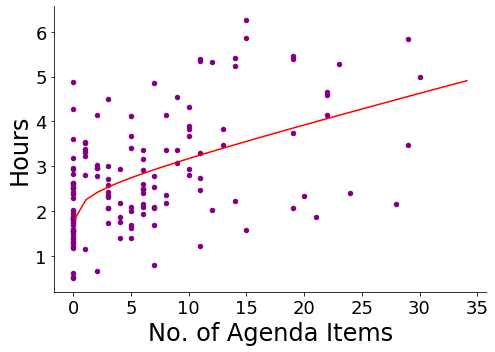

In [181]:
fig, ax = plt.subplots(figsize = (7,5))
mpdrih.plot.scatter(y='Hours', x="# Agenda Items", ax=ax, color='purple')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
lr_agenda = LinearRegression()
poly_df_agenda=df_agenda_terms
lr_agenda.fit(poly_df_agenda, mpdrih[['Hours']])
x = np.arange(.1,35,1)
ax.plot(x, lr_agenda.predict(get_xterms(x)),'r')
ax.set_xlabel('No. of Agenda Items',size=24)
ax.set_ylabel('Hours',size=24)
plt.xticks(size=18)
plt.yticks(size=18)
plt.tight_layout()


def formula(reg, columns):
    rv = ""
    for i in range(len(columns)):
        rv += "{}*{} + ".format(round(reg.coef_[0,i],4), columns[i])
    rv += str(lr_agenda.intercept_[0])
    return rv

print("Meeting Duration ~= " + formula(lr_agenda, poly_df_agenda.columns))

plt.savefig('DvsAI2.pdf', bbox='tight')

In [164]:
import sklearn
from sklearn import *

In [173]:
test_df_1 = df_agenda_terms.copy().copy()
test_df_1['Participants']=mpdrip['Participants']
test_df_1.replace(np.NaN, 0, inplace=True)
train, test = train_test_split(test_df_1)
clf_1 = linear_model.LinearRegression()
clf_1.fit(train.loc[:, train.columns != 'Participants'], train["Participants"])
print("Training Score: ",clf.score(train.loc[:, train.columns != 'Participants'], train["Participants"]),"\n"
 "Testing Score: ", clf.score(test.loc[:, test.columns != 'Participants'], test["Participants"]))

predicted_part = []
for index, rows in test_df_1.iterrows():
    predicted_part.append(clf_1.predict([[rows['x'],rows['logx']]])[0])
test_df_1['predicted']=predicted_part

Training Score:  0.18501951278797946 
Testing Score:  0.008489871369148472


In [175]:
sklearn.metrics.explained_variance_score(test_df_1['Participants'],test_df_1['predicted'])

0.1300491382483412

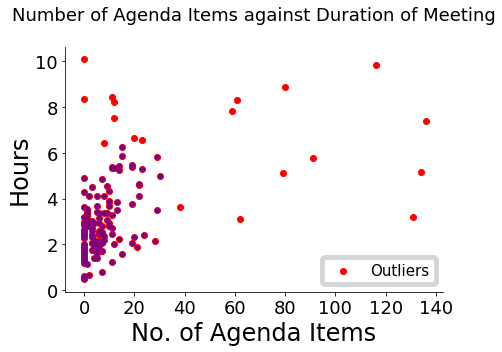

In [182]:
fig, ax = plt.subplots(figsize = (7,5))
plt.scatter(mpd["# Agenda Items"], mpd["Hours"], c = 'red', label='Outliers')
# plt.xticks(rotation=90)

plt.title("Number of Agenda Items against Duration of Meeting\n", fontsize=18)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
mpdrih.plot.scatter(y='Hours', x="# Agenda Items", ax=ax, color='purple')
plt.legend(prop={'size': 15}).get_frame().set_linewidth(5)
ax.set_xlabel('No. of Agenda Items',size=24)
ax.set_ylabel('Hours',size=24)
plt.xticks(size=18)
plt.yticks(size=18)

plt.tight_layout()


plt.savefig("DvsAI.pdf", bboxgrid="tight")
plt.show()

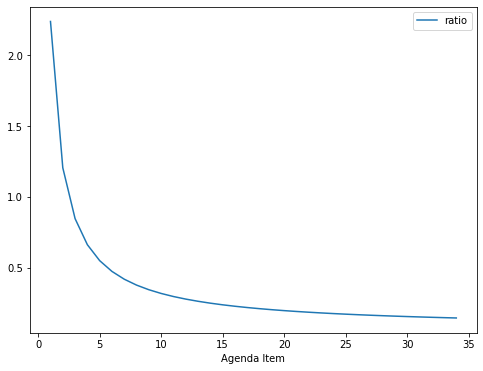

In [75]:
hour_predict = lr_agenda.predict(get_xterms(x))
hour_predict_df = pd.DataFrame({'Predicted':hour_predict.ravel(),'Agenda Item':x}, index=[i for i in range(1,35)])
hour_predict_df['ratio']=hour_predict_df['Predicted']/hour_predict_df['Agenda Item']
hour_predict_df.plot.line(x='Agenda Item',y='ratio')

In [76]:
hour_predict_df
hour_predict_df['% change']=''
hour_predict_df['% change'][1]=None
for i in range(2,len(hour_predict_df['Predicted'])+1):
#     print(part_predict_df['Predicted'][i])
    percent_change = (hour_predict_df['Predicted'][i]-hour_predict_df['Predicted'][i-1])/hour_predict_df['Predicted'][i-1]
    hour_predict_df['% change'][i]=round(percent_change*100,3)
    

<ipython-input-76-eafbd6c4f4f0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hour_predict_df['% change'][1]=None
<ipython-input-76-eafbd6c4f4f0>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hour_predict_df['% change'][i]=round(percent_change*100,3)


In [77]:
hour_predict_df

,Predicted,Agenda Item,ratio,% change
1,2.237648,1,2.237648,None
2,2.409510,2,1.204755,7.68
3,2.536645,3,0.845548,5.276
4,2.645466,4,0.661367,4.29
5,2.744254,5,0.548851,3.734
6,2.836695,6,0.472782,3.369
7,2.924756,7,0.417822,3.104
8,3.009611,8,0.376201,2.901
9,3.092017,9,0.343557,2.738
10,3.172492,10,0.317249,2.603


**TERRYS FITTING DATA END**

In [78]:
# Function to calculate the power-law with constants a and b
def power_law(x, a, b):
    return a*np.power(x, b)

In [79]:
pars, cov = curve_fit(f=power_law, xdata=mpdrih["# Agenda Items"].values, ydata=mpdrih["Hours"].values, p0=[0, 0], bounds=(-np.inf, np.inf))
pars, cov

(array([2.79987745, 0.        ]),
 array([[1.65097396e-02, 8.78660866e-11],
        [8.78660866e-11, 1.63070990e-18]]))

In [80]:
l = []
for i in range(mpdrih["# Agenda Items"].shape[0]):
    val = power_law(mpdrih.iloc[i]["# Agenda Items"], pars[0], pars[1])
    l.append(val)

In [81]:
ep = np.sum((l - mpdrih["Hours"].values) **2)
ep/len(mpdrih["# Agenda Items"])

1.5778941843281429

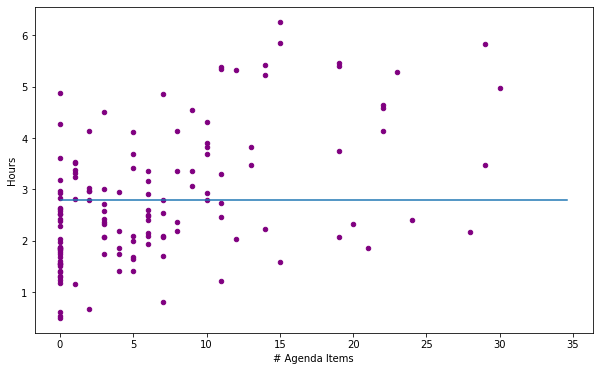

In [82]:
fig, ax = plt.subplots(figsize = (10,6))
mpdrih.plot.scatter(y='Hours', x="# Agenda Items", ax=ax, color='purple')
x = np.arange(0.1, 35, 0.5)
plt.plot(x, power_law(x, *pars))

In [83]:
ip1 = np.polyfit(mpdrip["# Agenda Items"], mpdrip["Participants"], 1, rcond=None, full=False)
ip1

array([ 1.22787193, 32.28003631])

In [84]:
ip2 = np.polyfit(mpdrip["# Agenda Items"], mpdrip["Participants"], 2, rcond=None, full=False)
ip2

array([-0.04942418,  2.36427372, 29.63874743])

In [85]:
ip3 = np.polyfit(mpdrip["# Agenda Items"], mpdrip["Participants"], 3, rcond=None, full=False)
ip3

array([ 7.22588842e-04, -7.71086499e-02,  2.60249487e+00,  2.94109935e+01])

In [86]:
ip4 = np.polyfit(mpdrip["# Agenda Items"], mpdrip["Participants"], 4, rcond=None, full=False)
ip4

array([ 2.90238557e-04, -1.51430607e-02,  1.82110233e-01,  1.36698904e+00,
        2.99293596e+01])

In [87]:
ip5 = np.polyfit(mpdrip["# Agenda Items"], mpdrip["Participants"], 5, rcond=None, full=False)
ip5

array([ 3.56610869e-05, -2.12490271e-03,  4.04296229e-02, -3.19111310e-01,
        2.84059001e+00,  2.96451062e+01])

In [88]:
ep1 = np.sum((np.polyval(np.polyfit(mpdrip["# Agenda Items"], mpdrip["Participants"], 1), mpdrip["# Agenda Items"]) - mpdrip["Participants"])**2)
ep1/len(mpdrip["# Agenda Items"])

371.40122322067856

In [89]:
ep2 = np.sum((np.polyval(np.polyfit(mpdrip["# Agenda Items"], mpdrip["Participants"], 2), mpdrip["# Agenda Items"]) - mpdrip["Participants"])**2)
ep2/len(mpdrip["# Agenda Items"])

361.1909545681546

In [90]:
ep3 = np.sum((np.polyval(np.polyfit(mpdrip["# Agenda Items"], mpdrip["Participants"], 3), mpdrip["# Agenda Items"]) - mpdrip["Participants"])**2)
ep3/len(mpdrip["# Agenda Items"])

361.0534210124892

In [91]:
ep4 = np.sum((np.polyval(np.polyfit(mpdrip["# Agenda Items"], mpdrip["Participants"], 4), mpdrip["# Agenda Items"]) - mpdrip["Participants"])**2)
ep4/len(mpdrip["# Agenda Items"])

359.9724291504282

In [92]:
ep5 = np.sum((np.polyval(np.polyfit(mpdrip["# Agenda Items"], mpdrip["Participants"], 5), mpdrip["# Agenda Items"]) - mpdrip["Participants"])**2)
ep5/len(mpdrip["# Agenda Items"])

359.3177487602949

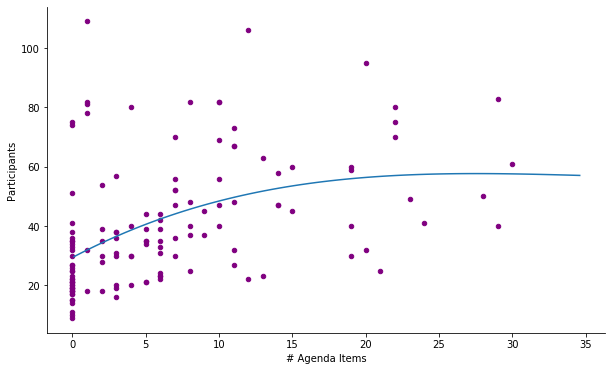

In [93]:
fig, ax = plt.subplots(figsize = (10,6))
mpdrip.plot.scatter(y='Participants', x="# Agenda Items", ax=ax, color='purple')
x = np.arange(0.1, 35, 0.5)
trendpoly = np.poly1d(ip3) 
plt.plot(x,trendpoly(x))
#plt.plot(X, lr.predict(get_xterms(x)), color='r')
#ax.set_ylabel("Average Meeting Duration in Hours", fontsize=16)
#ax.set_xlabel("Average Number of Meeting Participants", fontsize=16)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.set_title('Average Number of Participants by \nAverage Meeting Duration in Hours for each Committee\n', fontsize=20)
#plt.savefig("PvsD2.png", bbox_inches = "tight")
None

In [94]:
pars2, cov2 = curve_fit(f=power_law, xdata=mpdrip["# Agenda Items"].values, ydata=mpdrip["Participants"].values, p0=[0, 0], bounds=(-np.inf, np.inf))
pars2, cov2

<ipython-input-78-9580fdef6160>:3: RuntimeWarning: divide by zero encountered in power
  return a*np.power(x, b)


(array([8.6710997, 0.       ]),
 array([[1.57893998e+01, 2.71338564e-08],
        [2.71338564e-08, 1.59017352e-16]]))

In [95]:
ll = []
for i in range(mpdrip["# Agenda Items"].shape[0]):
    val = power_law(mpdrip.iloc[i]["# Agenda Items"], pars[0], pars[1])
    ll.append(val)

In [96]:
eh = np.sum((ll - mpdrip["Participants"].values) **2)
eh/len(mpdrip["# Agenda Items"])

1869.089820521709

**TERRYS FITTING DATA START - PARTICIPANTS VS. AGENDA**

In [97]:
df_agenda_PART = get_xterms(mpdrip['# Agenda Items'])
df_agenda_PART.replace(np.NINF, 0, inplace=True)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Meeting Participants ~= 0.7871*x + 3.1594*logx + 30.921702708649978


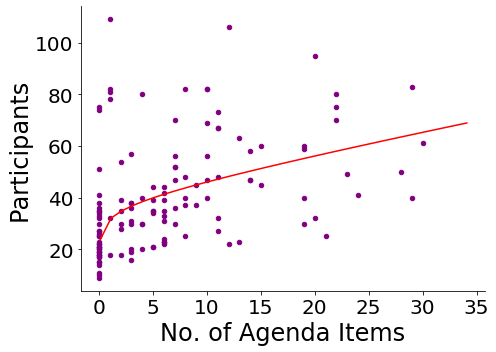

In [183]:
fig, ax = plt.subplots(figsize = (7,5))
mpdrip.plot.scatter(y='Participants', x="# Agenda Items", ax=ax, color='purple')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
lr_agenda_PART = LinearRegression()
poly_df_agenda_PART=df_agenda_PART
lr_agenda_PART.fit(poly_df_agenda_PART, mpdrip[['Participants']])
x = np.arange(.1,35,1)
ax.plot(x, lr_agenda_PART.predict(get_xterms(x)),'r')
ax.set_xlabel('No. of Agenda Items',size=24)
ax.set_ylabel('Participants',size=24)
plt.xticks(size=20)
plt.yticks(size=20)

def formula(reg, columns):
    rv = ""
    for i in range(len(columns)):
        rv += "{}*{} + ".format(round(reg.coef_[0,i],4), columns[i])
    rv += str(lr_agenda_PART.intercept_[0])
    return rv

print("Meeting Participants ~= " + formula(lr_agenda_PART, poly_df_agenda_PART.columns))



plt.tight_layout()


plt.savefig('PvsAI2.pdf', bbox='tight')

In [145]:
test_df = df_agenda_PART.copy().copy()
test_df['Participants']=mpdrip['Participants']
train, test = train_test_split(test_df)
clf = linear_model.LinearRegression()
clf.fit(train.loc[:, train.columns != 'Participants'], train["Participants"])
print("Training Score: ",clf.score(train.loc[:, train.columns != 'Participants'], train["Participants"]),"\n"
 "Testing Score: ", clf.score(test.loc[:, test.columns != 'Participants'], test["Participants"]))


Training Score:  0.17045834542604466 
Testing Score:  0.21610190175312693


In [160]:
predicted_part = []
for index, rows in test_df.iterrows():
    predicted_part.append(clf.predict([[rows['x'],rows['logx']]])[0])
test_df['predicted']=predicted_part

In [163]:
sklearn.metrics.explained_variance_score(test_df['Participants'],test_df['predicted'])

0.18512355471653996

**done testing **

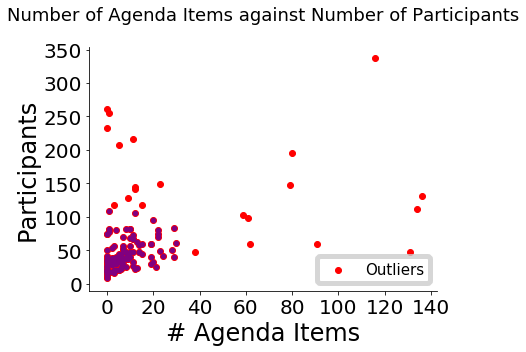

In [184]:
fig, ax = plt.subplots(figsize = (7,5))


plt.scatter(mpd["# Agenda Items"], mpd["Participants"], c= 'red', label='Outliers')
# plt.xticks(rotation=90)
plt.xlabel("No. of Agenda Items", fontsize=24)
plt.ylabel("Participants", fontsize=24)
plt.title("Number of Agenda Items against Number of Participants\n", fontsize=18)
plt.xticks(size=20)
plt.yticks(size=20)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
mpdrip.plot.scatter(y='Participants', x="# Agenda Items", ax=ax, color='purple')

plt.tight_layout()



plt.legend(loc='lower right', prop={'size': 15}).get_frame().set_linewidth(5)
plt.savefig("PvsAI.pdf", bboxgrid="tight")
plt.show()

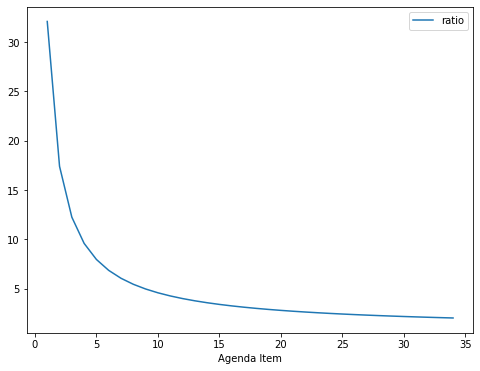

In [243]:
part_predict = lr_agenda_PART.predict(get_xterms(x))
part_predict_df = pd.DataFrame({'Predicted':part_predict.ravel(),'Agenda Item':x}, index=[i for i in range(1,35)])
part_predict_df['ratio']=part_predict_df['Predicted']/part_predict_df['Agenda Item']
part_predict_df.plot.line(x='Agenda Item', y='ratio')

In [295]:
part_predict_df['% change']=''
part_predict_df['% change'][1]=None
for i in range(2,len(part_predict_df['Predicted'])+1):
#     print(part_predict_df['Predicted'][i])
    percent_change = (part_predict_df['Predicted'][i]-part_predict_df['Predicted'][i-1])/part_predict_df['Predicted'][i-1]
    part_predict_df['% change'][i]=round(percent_change*100,3)
    

<ipython-input-295-0d7b5722083e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part_predict_df['% change'][1]=None
<ipython-input-295-0d7b5722083e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part_predict_df['% change'][i]=round(percent_change*100,3)


**TERRYS FITTING DATA END**

In [296]:
part_predict_df

,Predicted,Agenda Item,ratio,% change
1,32.095933,1,32.095933,None
2,34.822333,2,17.411166,8.495
3,36.761909,3,12.253970,5.57
4,38.379343,4,9.594836,4.4
5,39.820261,5,7.964052,3.754
6,41.149529,6,6.858255,3.338
7,42.401748,7,6.057393,3.043
8,43.597573,8,5.449697,2.82
9,44.750325,9,4.972258,2.644
10,45.869101,10,4.586910,2.5


**Combining the Plots for Ratios**

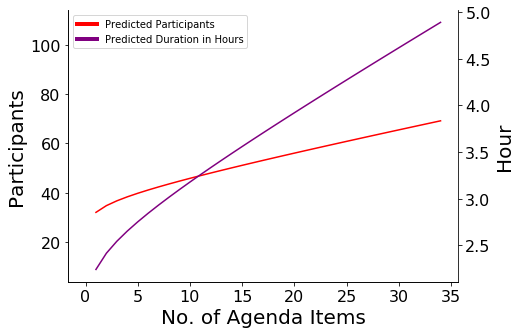

In [342]:
fig, ax = plt.subplots(figsize = (7,5))
mpdrip.plot.scatter(y='Participants', x="# Agenda Items", ax=ax, color='white')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

part_predict_df.plot.line(x='Agenda Item', y='Predicted', ax=ax, label = 'Predicted Participants',color='red')
ax.set_xlabel('No. of Agenda Items',size=20)
ax.set_ylabel('Participants',size=20)
plt.xticks(size=16)
plt.yticks(size=16)

ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Hour',size=20)
# part_predict_df.plot.line(x='Agenda Item', y='% change', ax=ax2, color='purple',legend=False)
hour_predict_df.plot.line(x='Agenda Item', y='Predicted', ax=ax2, label = 'Predicted Duration',color='purple', legend=False)
plt.yticks(size=16)

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='red', lw=4),
#                 Line2D([0], [0], color='green', lw=4),
                Line2D([0], [0], color='purple', lw=4)]
ax.legend(custom_lines, ['Predicted Participants', 'Predicted Duration in Hours'], loc='upper left')

# ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)





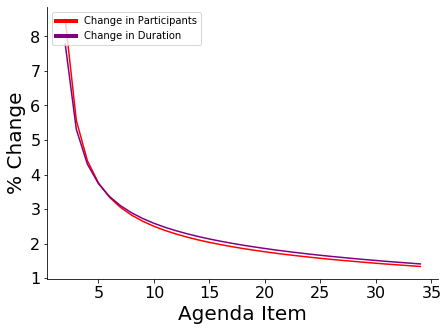

In [340]:
fig, ax = plt.subplots(figsize = (7,5))
# mpdrip.plot.scatter(y='Participants', x="# Agenda Items", ax=ax, color='white')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

part_predict_df.plot.line(x='Agenda Item', y='% change', ax=ax, label = '% Change Participants',color='red')
ax.set_xlabel('No. of Agenda Items',size=20)
ax.set_ylabel('% Change',size=20)
plt.xticks(size=16)
plt.yticks(size=16)

# ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
# ax2.set_ylabel('Hour',size=20)
# part_predict_df.plot.line(x='Agenda Item', y='% change', ax=ax2, color='purple',legend=False)
hour_predict_df.plot.line(x='Agenda Item', y='% change', ax=ax, label = '% Change Duration',color='purple', legend=False)
plt.yticks(size=16)

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='red', lw=4),
#                 Line2D([0], [0], color='green', lw=4),
                Line2D([0], [0], color='purple', lw=4)]
ax.legend(custom_lines, ['Change in Participants', 'Change in Duration'], loc='upper left')








In [347]:
from sklearn.linear_model import LinearRegression as LR

df = mpd[['Hours','Participants']]

In [348]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(4, include_bias=False)
columns = ["Hours"]
arr = poly.fit_transform(df[columns])
poly_df = pd.DataFrame(arr)
poly_df = pd.DataFrame(arr, columns=poly.get_feature_names(columns))
poly_df

,Hours,Hours^2,Hours^3,Hours^4
0,2.783333,7.746944,21.562329,60.015148
1,9.816667,96.366944,946.002171,9286.587982
2,2.150000,4.622500,9.938375,21.367506
3,2.933333,8.604444,25.239704,74.036464
4,4.650000,21.622500,100.544625,467.532506
...,...,...,...,...
150,2.516667,6.333611,15.939588,40.114630
151,4.133333,17.084444,70.615704,291.878242
152,2.483333,6.166944,15.314579,38.031204
153,2.816667,7.933611,22.346338,62.942185


In [349]:
lr = LR()
lr.fit(poly_df, df[["Participants"]])
lr.coef_, lr.intercept_

(array([[-2.45581836,  7.59015311, -1.40356722,  0.0940675 ]]),
 array([16.93211816]))

Meeting Duration ~= -2.4558183597275276*Hours + 7.590153109380815*Hours^2 + -1.4035672193130861*Hours^3 + 0.0940674977837066*Hours^4 + 16.93211815545294


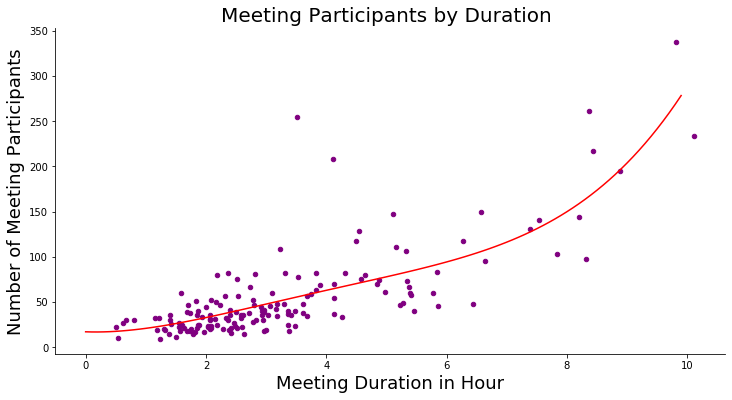

In [351]:
fig, ax = plt.subplots(figsize = (12,6))
df.plot.scatter(x="Hours", y="Participants", color="purple", ax=ax)
ax.set_xlabel("Meeting Duration in Hour",size=18)
ax.set_ylabel("Number of Meeting Participants",size=18)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title('Meeting Participants by Duration ',size=20)


# compute coords along fit line, then plot it
fit_x = np.arange(0, 10, 0.1).reshape(-1,1)
fit_y = lr.predict(poly.fit_transform(fit_x))
ax.plot(fit_x, fit_y, "red")

def formula(reg, columns):
    rv = ""
    for i in range(len(columns)):
        rv += "{}*{} + ".format(round(reg.coef_[0,i],100), columns[i])
    rv += str(lr.intercept_[0])
    return rv

print("Meeting Duration ~= " + formula(lr, poly_df.columns))
plt.savefig('meeting_participants.PDF',bbox_inches = "tight")

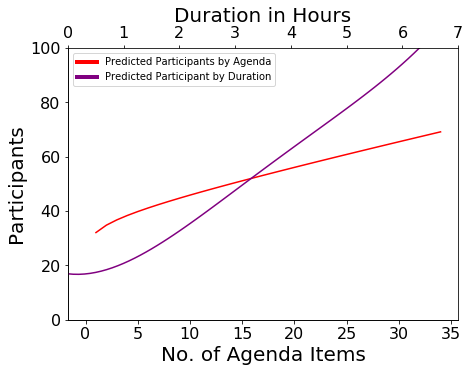

In [366]:
fig, ax = plt.subplots(figsize = (7,5))
mpdrip.plot.scatter(y='Participants', x="# Agenda Items", ax=ax, color='white')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

part_predict_df.plot.line(x='Agenda Item', y='Predicted', ax=ax, label = 'Predicted Participants',color='red')
ax.set_xlabel('No. of Agenda Items',size=20)
ax.set_ylabel('Participants',size=20)
plt.xticks(size=16)
plt.yticks(size=16)
ax.set_ylim(0,100)

ax2 = ax.twiny()  # instantiate a second axes that shares the same x-axis
plt.xticks(size=16)
ax2.plot(fit_x, fit_y, "purple")
ax2.set_xlabel('Duration in Hours',size=20)
ax2.set_xlim(0,7)






from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='red', lw=4),
#                 Line2D([0], [0], color='green', lw=4),
                Line2D([0], [0], color='purple', lw=4)]
ax.legend(custom_lines, ['Predicted Participants by Agenda', 'Predicted Participant by Duration'], loc='upper left')
plt.savefig('predicted.pdf',bbox='tight')




